In [516]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [517]:
class DataPlotter:
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def get_all_features_observed(self):
        x_train_observed = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        return x_train_observed.columns

    def get_all_features_estimated(self):
        x_train_estimated = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        return x_train_estimated.columns
    
    def get_correlation(self, df, feature):
        with np.errstate(divide='ignore', invalid='ignore'):
            correlation = df[feature].corr(df['pv_measurement'])
            if np.isnan(correlation) or np.isinf(correlation):
                correlation = 0.0  # Handle the case when correlation is NaN or Inf
        return correlation
    
    def plot_feature_against_y(self, feature, observed, plot, hour=None, month=None):
        if observed:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        else:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        
        # Convert 'time' and 'date_forecast' columns to datetime format
        y_train['time'] = pd.to_datetime(y_train['time'])
        x_train['date_forecast'] = pd.to_datetime(x_train['date_forecast'])

        if (hour and month) is not None:
            y_train_at_hour_and_month = y_train[
                (y_train['time'].dt.hour == hour) & (y_train['time'].dt.month == month)
            ]
            x_train_at_hour_and_month = x_train[
                (x_train['date_forecast'].dt.hour == hour) & (x_train['date_forecast'].dt.month == month)
            ]
            merged_df = pd.merge(
                y_train_at_hour_and_month, x_train_at_hour_and_month,
                left_on='time', right_on='date_forecast'
            )
        elif hour is not None and month is None:
            y_train_at_hour = y_train[y_train['time'].dt.hour == hour]
            x_train_at_hour = x_train[x_train['date_forecast'].dt.hour == hour]
            merged_df = pd.merge(
                y_train_at_hour, x_train_at_hour, left_on='time', right_on='date_forecast'
            )
        elif month is not None and hour is None:
            y_train_at_month = y_train[y_train['time'].dt.month == month]
            x_train_at_month = x_train[x_train['date_forecast'].dt.month == month]
            merged_df = pd.merge(
                y_train_at_month, x_train_at_month, left_on='time', right_on='date_forecast'
            )
        elif not month and not hour:
            merged_df = pd.merge(y_train , x_train, left_on='time', right_on='date_forecast')
        
        merged_df = merged_df.dropna(subset=[feature, 'pv_measurement'])
        corr = self.get_correlation(df = merged_df, feature=feature)

        if plot:
            plt.figure(figsize=(6, 4))
            plt.scatter(merged_df[feature], merged_df['pv_measurement'], alpha=1)
            plt.xlabel(feature)
            plt.ylabel('PV Measurement')
            plt.title(feature + ' vs PV Measurement')
            plt.grid(True)
            plt.show()

        if math.isnan(corr):
            return 0
        
        return corr
    
    def plot_feature_analysis(self, observed, plot, feature=None, hour=None, month=None):
        if observed:
            if feature:
                print(feature + " FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_observed():
                    self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
        else:
            if feature:
                print(feature + " FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_estimated():
                    self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)

## Plot your desired feature against a spesific month and hour

- You can choose hour and month to be None to get a more general view of the data
- Note that sometimes there few datapoints when having to much spesifisty, hence the correlation might be "skewed".

ceiling_height_agl:m FROM ESTIMATED DATASET FROM LOCATION A.


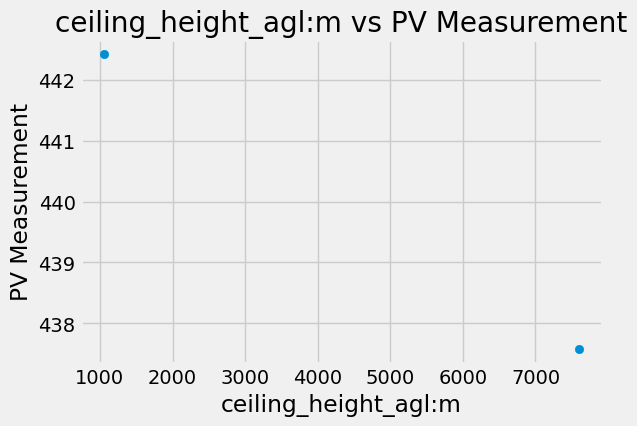

Correlation is -1.0


In [518]:
# Choose what dataset you want your values from (observed = False gets the estimated dataset).
# Spesify hour (example: 12) and/or month (example: 6). Either of them can be None.
# Choose your feature. If you spesify 'feature' to be None, then it will plot for ALL feautures.


dataset = 'A'
observed = False
hour = 9
month = 10
feature = 'ceiling_height_agl:m'

plotter = DataPlotter(dataset)

corr = plotter.plot_feature_analysis(observed=observed, plot=True, feature=feature, hour=hour, month=month)
if corr is not None:
    print("Correlation is", round(corr, 10))


In [519]:
# A class to aid the function below

class Observation:
    def __init__(self, feature, hour, month, corr) -> None:
        self.feature = feature
        self.hour = hour
        self.month = month
        self.corr = corr

# Sorting on Correlation

The code snippet below will go through all combinations of hours, months and feature and sort the different cases on correlation. The output is a csv file. Note that this will take about 4-5 min to run on an Apple silicon M1 processor. 

- When running you might encounter the error "RuntimeWarning: Degrees of freedom <= 0 for slice". This happens when data you're working with is insufficient to compute that statistic. One common scenario is when computing the variance or standard deviation of a dataset with a single value or no values.
    - This makes since for some cases there are not many data points.

In [ ]:
# ITERATE THROUGH ALL COMBINATIONS OF MONTHS AND HOURS FOR A CHOSEN LOCATION AND SORT ON CORRELATION
# CREATES .CSV FILE
# NOTE Takes a long time to run

dataset = 'C'
observed = False

########################################################################################################################
plotter = DataPlotter(dataset)

if observed: all_features = plotter.get_all_features_observed()
else: all_features = plotter.get_all_features_estimated()

hours = list(range(24))
months = list(range(1, 13))

observations = []
for feature in all_features:
    for hour in hours:
        for month in months:
            corr = plotter.plot_feature_against_y(feature=feature, observed=observed, plot=False, hour=hour, month=month)
            obsvervation = Observation(feature, hour, month, corr)
            observations.append(obsvervation)

sorted_observations = sorted(observations, key=lambda x: -abs(x.corr))

if observed: csv_filename = "sorted_feature_correlations_" + dataset + "_observed.csv"
else: csv_filename = "sorted_feature_correlations_" + dataset + "_estimated.csv"

with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Feature', 'Hour', 'Month', 'Correlation'])

    for obs in sorted_observations:
        row_data = [obs.feature, obs.hour, obs.month, obs.corr]
        csv_writer.writerow(row_data)

print(f"CSV file '{csv_filename}' has been created.")

# Analysing the Correlation Data

We can see that the feature correlations vary a lot with different hours and months. This is natural since, for instance, there is no sun at night time. Notice that the correlation of many features are much higher when approaching summer months as well.

To analyse the correlation data we can look at the average correlation of each feature irregardles of the hour or month. Then we can look at the same with hour and month in mind. Hence we can extrapolate what feature seem to be important.

In [521]:
# Choose location and observed/estimated, then run the analysis

location = 'B'
observed = True

if observed: csv_filename = location + "/sorted_feature_correlations_" + location + "_observed.csv"
else: csv_filename = location + "/sorted_feature_correlations_" + location + "_estimated.csv"

df = pd.read_csv(csv_filename)

When looking at the average correlation of the features (ranked in the absolute value of the correlation) for all the locations we can state the following:

Location A:
- **direct_rad_1h:J** has the highest correlation for observed/estimated
 - Other top correlated features seem to be **effective_cloud_cover:p**, **total_cloud_cover:p**, **visibility:m** etc.

Location B:
 - **direct_rad:W** and **direct_rad_1h:J** are on top
 - **sun_elevation:d** has some higher importance here

 Location C:
  - **direct_rad_1h:J** and **direct_rad_1h:J** are on top

  Note that cloud cover has a negative correlation

In [522]:
avg_correlation = df.groupby('Feature')['Correlation'].mean().reset_index()

avg_correlation.sort_values(by='Correlation', key=abs, ascending=False).head(10)

Feature  Correlation
11                 direct_rad:W     0.233218
12              direct_rad_1h:J     0.229888
37              sun_elevation:d     0.171454
13      effective_cloud_cover:p    -0.166713
3         clear_sky_energy_1h:J     0.153714
4               clear_sky_rad:W     0.150085
41                 visibility:m     0.137576
29  relative_humidity_1000hPa:p    -0.133272
40          total_cloud_cover:p    -0.133161
5              cloud_base_agl:m     0.131772

## Now including hour and month in our analysis

**NOTE:** Some correlations are 1 or -1. This is because some instances might have only one or two datapoints leading to an inaccurate estimate of the correlation.

- We can look at the top correlated features for every month then for every hour.

In [523]:
# Outputs top features with the highest correlations when INCLUDING HOUR AND MONTH

df = pd.read_csv(csv_filename)
df.head(10)

Feature  Hour  Month  Correlation
0  clear_sky_energy_1h:J     8     11     0.830680
1        clear_sky_rad:W     8     11     0.823640
2       is_in_shadow:idx     8     11    -0.811408
3        direct_rad_1h:J     8     10     0.792964
4       diffuse_rad_1h:J     8     11     0.791008
5          diffuse_rad:W     8     11     0.790991
6           direct_rad:W     8     10     0.787655
7  clear_sky_energy_1h:J    10     11     0.785969
8          diffuse_rad:W    13     11     0.784049
9        clear_sky_rad:W    10     11     0.783330

### What does the every month analysis tell us?

- When analysing the observed data for all three locations the summer month seem to be more reliant on radiation. Whilst in the winter months features like **absolute_humidity_2m:gm3** and **clear_sky_energy_1h:J** takes over (locations B and C, but not A).
- The analysis seems to break down for the estimated datasets due to the skewed correlations, because of the lack of sufficient data.

In [524]:
# The most highly correlated value for EVERY MONTH

df['Month'] = pd.Categorical(df['Month'], categories=df['Month'].unique(), ordered=True)
max_corr_rows = pd.DataFrame()

for month in df['Month'].cat.categories:
    monthly_data = df[df['Month'] == month]
    
    max_corr_idx = monthly_data['Correlation'].idxmax()
    
    max_corr_rows = pd.concat([max_corr_rows, df.loc[[max_corr_idx]]], ignore_index=True)

# Sort max_corr_rows by the 'Month' column
max_corr_rows['Month'] = max_corr_rows['Month'].astype(int)  # Ensure 'Month' is an integer type for proper sorting
max_corr_rows.sort_values('Month', inplace=True)
max_corr_rows.reset_index(drop=True, inplace=True)

max_corr_rows

Feature  Hour  Month  Correlation
0               direct_rad:W    14      1     0.503278
1   absolute_humidity_2m:gm3    15      2     0.557116
2               direct_rad:W     8      3     0.401765
3               direct_rad:W     7      4     0.751622
4               direct_rad:W     7      5     0.767097
5               direct_rad:W     9      6     0.779392
6            direct_rad_1h:J     5      7     0.705664
7              sun_azimuth:d    16      8     0.621222
8            direct_rad_1h:J     6      9     0.733117
9            direct_rad_1h:J     8     10     0.792964
10     clear_sky_energy_1h:J     8     11     0.830680
11           clear_sky_rad:W     9     12     0.433177

### What does the every hour analysis tell us?

- At nighttime these feature appear more often:
    - **date_forecast**
    - **visibility:m**
    - **sfc_pressure:hPa** 
------------------------------------
- At daytime these features dominate:
    - **Radiation (direct early in the morning, then diffuse radiontion in the afternoon)**
    - **clear_sky_energy_1h:J**

In [525]:
# The most highly correlated value for EVERY HOUR

max_corr_rows = pd.DataFrame()

for hour in range(0, 24):  
    hourly_data = df[df['Hour'] == hour]
    
    if not hourly_data.empty:  
        max_corr_idx = hourly_data['Correlation'].idxmax()
        max_corr_rows = pd.concat([max_corr_rows, df.loc[[max_corr_idx]]], ignore_index=True)

max_corr_rows.sort_values('Hour', inplace=True)
max_corr_rows.reset_index(drop=True, inplace=True)

max_corr_rows


Feature  Hour Month  Correlation
0           date_forecast     0     9     0.585378
1           date_forecast     1     9     0.575023
2           date_forecast     2     9     0.575023
3           date_forecast     3     9     0.575023
4            direct_rad:W     4     5     0.666494
5         direct_rad_1h:J     5     6     0.709759
6         direct_rad_1h:J     6     9     0.733117
7        diffuse_rad_1h:J     7    10     0.770198
8   clear_sky_energy_1h:J     8    11     0.830680
9            direct_rad:W     9     6     0.779392
10  clear_sky_energy_1h:J    10    11     0.785969
11  clear_sky_energy_1h:J    11    11     0.748254
12           direct_rad:W    12     6     0.734934
13          diffuse_rad:W    13    11     0.784049
14           direct_rad:W    14     6     0.753942
15        clear_sky_rad:W    15    10     0.709678
16        direct_rad_1h:J    16     6     0.687194
17          sun_azimuth:d    17     4     0.621118
18          date_forecast    18     9     0.552941
19          date_forecast    19     9     0.555957
20          date_forecast    20     9     0.555957
21          date_forecast    21     9     0.555957
22          date_forecast    22     9     0.545367
23          date_forecast    23     9     0.567336

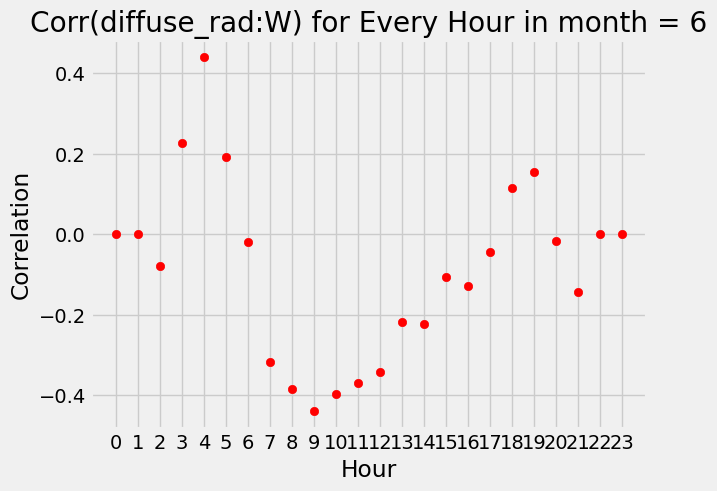

In [526]:
# Plot a the correlation of a feature for a spesific month for every hour
# Choose month and feature

month = 6
feature = 'diffuse_rad:W'

filtered_data = df[(df['Feature'] == feature) & (df['Month'] == month)]

# Creating a scatter plot of the correlation values for each hour.
plt.scatter(filtered_data['Hour'], filtered_data['Correlation'], color='red')
plt.xticks(range(0, 24))  
plt.title('Corr(' + feature + ') for Every Hour in month = ' + str(month))
plt.xlabel('Hour')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()


# Lets do some Exploratory Analysis

Let us examine the data more carefully using pandas.

In [527]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

## Differing times for each location

- Each location begins to record at a different date, although they all end at the same date. 
- Another thing of notice is that location B seems to start its readings the earliest, then comes A and C at least with quite a significant margin.

train_a head:


time  pv_measurement
0 2019-06-02 22:00:00             0.0
1 2019-06-02 23:00:00             0.0
2 2019-06-03 00:00:00             0.0

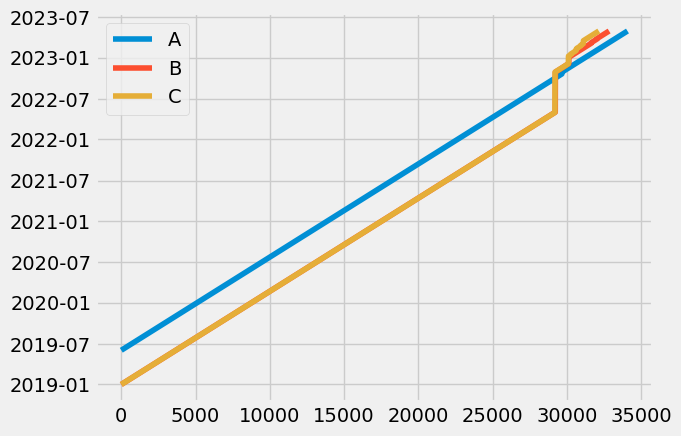

In [528]:
train_a['time'].plot(label="A")
train_b['time'].plot(label="B")
train_c['time'].plot(label="C")
plt.legend()

print("train_a head:")
train_a.head(3)

## How about plotting pv measurment against time for all three locations?

Thing of notice:
- Location B and C has missing datapoints at some point
- The amplitude of the readings from location A are much higher than the other two locations.
    - This could happen if for example location A has more solar pannels
- Possible solutions could be to use min-max scaling

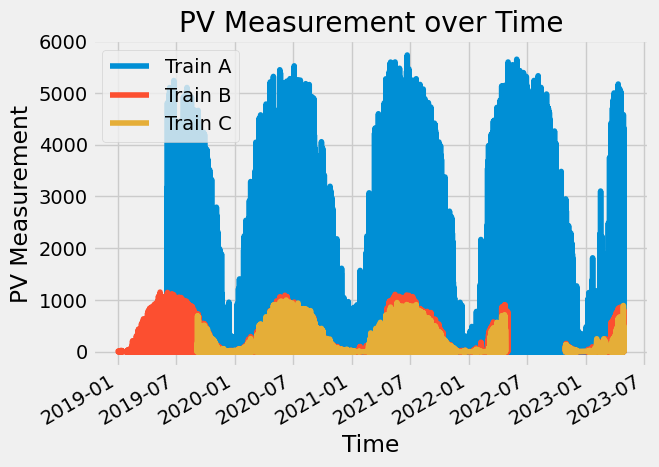

In [529]:
fig, ax = plt.subplots()

train_a.plot(x='time', y='pv_measurement', ax=ax, label='Train A')
train_b.plot(x='time', y='pv_measurement', ax=ax, label='Train B')
train_c.plot(x='time', y='pv_measurement', ax=ax, label='Train C')

ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()

plt.show()

### An issue with data from location B

- There is a gap in the data around 2020
 - This might be due to some technical issues with the measuring equipment

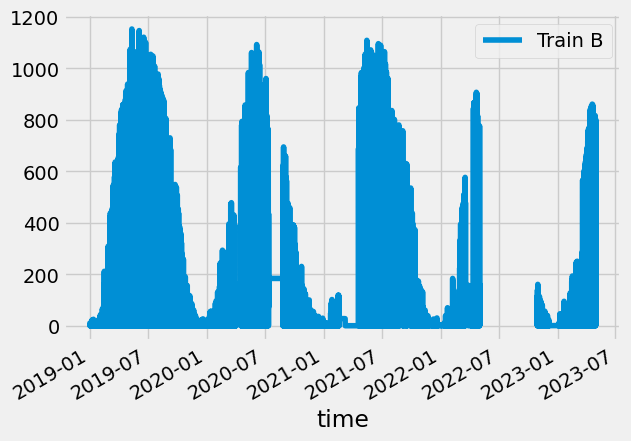

In [530]:
train_b.plot(x='time', y='pv_measurement', label='Train B')
ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()
plt.show()

## Let us examin both the observed and estimated dataset for all the locations starting with A

We will examine 
- Datashapes
- Datatypes
- Columns
- NaN values
- Some plots
- A correlation matrix

In [531]:
X_train_observed_a.head()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-06-02 22:00:00                       7.7                1.230   
1 2019-06-02 22:15:00                       7.7                1.229   
2 2019-06-02 22:30:00                       7.7                1.228   
3 2019-06-02 22:45:00                       7.7                1.226   
4 2019-06-02 23:00:00                       7.7                1.225   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1744.900024                    0.0              0.0   
1           1734.000000                    0.0              0.0   
2           1723.500000                    0.0              0.0   
3           1713.400024                    0.0              0.0   
4           1703.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1744.900024              0.0      280.299988            0.0  ...   
1       1734.000000              0.0      280.299988            0.0  ...   
2       1723.500000              0.0      280.299988            0.0  ...   
3       1713.400024              0.0      280.299988            0.0  ...   
4       1703.599976              0.0      280.299988            0.0  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     342.834015           -3.202                             0.0   
1     346.294006           -3.650                             0.0   
2     349.768005           -3.998                             0.0   
3     353.251007           -4.247                             0.0   
4     356.742004           -4.393                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   285.899994                100.0  39640.101562                3.7   
1   286.100006                100.0  40123.898438                3.6   
2   286.299988                100.0  40628.300781                3.6   
3   286.600006                100.0  41153.601562                3.5   
4   286.799988                100.0  41699.898438                3.5   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -3.6                 -0.8                     -0.0  
1                 -3.6                 -0.6                     -0.0  
2                 -3.6                 -0.4                     -0.0  
3                 -3.5                 -0.2                     -0.0  
4                 -3.5                  0.0                     -0.0  

[5 rows x 46 columns]

In [532]:
X_train_estimated_a.head()

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2022-10-27 07:00:18 2022-10-28 22:00:00                       8.4   
1 2022-10-27 07:00:18 2022-10-28 22:15:00                       8.4   
2 2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3 2022-10-27 07:00:18 2022-10-28 22:45:00                       8.3   
4 2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.233           1425.099976                    0.0   
1                1.233           2085.899902                    0.0   
2                1.233           2746.600098                    0.0   
3                1.233           3407.399902                    0.0   
4                1.233           4068.199951                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1211.699951              1.0      281.399994  ...   
1              0.0       1560.500000              1.0      281.299988  ...   
2              0.0       1909.400024              1.0      281.200012  ...   
3              0.0       2258.199951              1.0      281.200012  ...   
4              0.0       2607.000000              1.0      281.100006  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     340.799011       -38.466999                             0.0   
1     345.451996       -38.955002                             0.0   
2     350.153015       -39.310001                             0.0   
3     354.886993       -39.528999                             0.0   
4     359.638000       -39.609001                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   284.700012                100.0  29429.699219                0.8   
1   284.700012                100.0  23604.099609                0.7   
2   284.700012                100.0  17799.800781                0.7   
3   284.600006                100.0  12016.500000                0.6   
4   284.600006                100.0   6254.399902                0.6   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -0.4                  0.7                     -0.0  
1                 -0.4                  0.7                     -0.0  
2                 -0.3                  0.6                     -0.0  
3                 -0.2                  0.6                     -0.0  
4                 -0.1                  0.6                     -0.0  

[5 rows x 47 columns]

In [533]:
X_train_estimated_a.shape, X_train_observed_a.shape


((17576, 47), (118669, 46))

In [534]:
X_train_observed_a.dtypes

date_forecast                     datetime64[us]
absolute_humidity_2m:gm3                 float32
air_density_2m:kgm3                      float32
ceiling_height_agl:m                     float32
clear_sky_energy_1h:J                    float32
clear_sky_rad:W                          float32
cloud_base_agl:m                         float32
dew_or_rime:idx                          float32
dew_point_2m:K                           float32
diffuse_rad:W                            float32
diffuse_rad_1h:J                         float32
direct_rad:W                             float32
direct_rad_1h:J                          float32
effective_cloud_cover:p                  float32
elevation:m                              float32
fresh_snow_12h:cm                        float32
fresh_snow_1h:cm                         float32
fresh_snow_24h:cm                        float32
fresh_snow_3h:cm                         float32
fresh_snow_6h:cm                         float32
is_day:idx          

In [535]:
X_train_observed_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [536]:
X_train_observed_a.isna().sum()

date_forecast                          0
absolute_humidity_2m:gm3               0
air_density_2m:kgm3                    0
ceiling_height_agl:m               22247
clear_sky_energy_1h:J                  0
clear_sky_rad:W                        0
cloud_base_agl:m                    8066
dew_or_rime:idx                        0
dew_point_2m:K                         0
diffuse_rad:W                          0
diffuse_rad_1h:J                       0
direct_rad:W                           0
direct_rad_1h:J                        0
effective_cloud_cover:p                0
elevation:m                            0
fresh_snow_12h:cm                      0
fresh_snow_1h:cm                       0
fresh_snow_24h:cm                      0
fresh_snow_3h:cm                       0
fresh_snow_6h:cm                       0
is_day:idx                             0
is_in_shadow:idx                       0
msl_pressure:hPa                       0
precip_5min:mm                         0
precip_type_5min

In [537]:
X_train_estimated_a.isna().sum()

date_calc                             0
date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               3919
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   2094
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0


In [538]:
X_train_observed_a.loc[X_train_observed_a.duplicated()]

Empty DataFrame
Columns: [date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
Index: []

[0 rows x 46 columns]

In [539]:
X_train_estimated_a.loc[X_train_estimated_a.duplicated()]

Empty DataFrame
Columns: [date_calc, date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
Index: []

[0 rows x 47 columns]

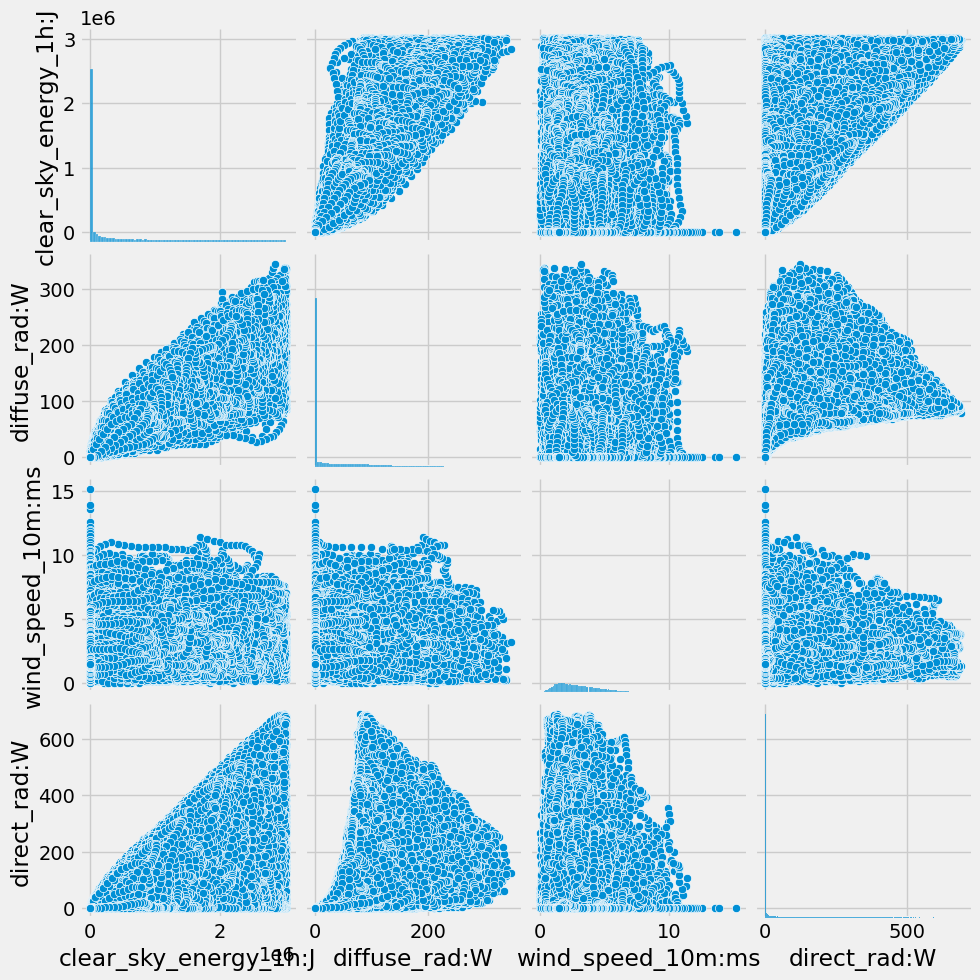

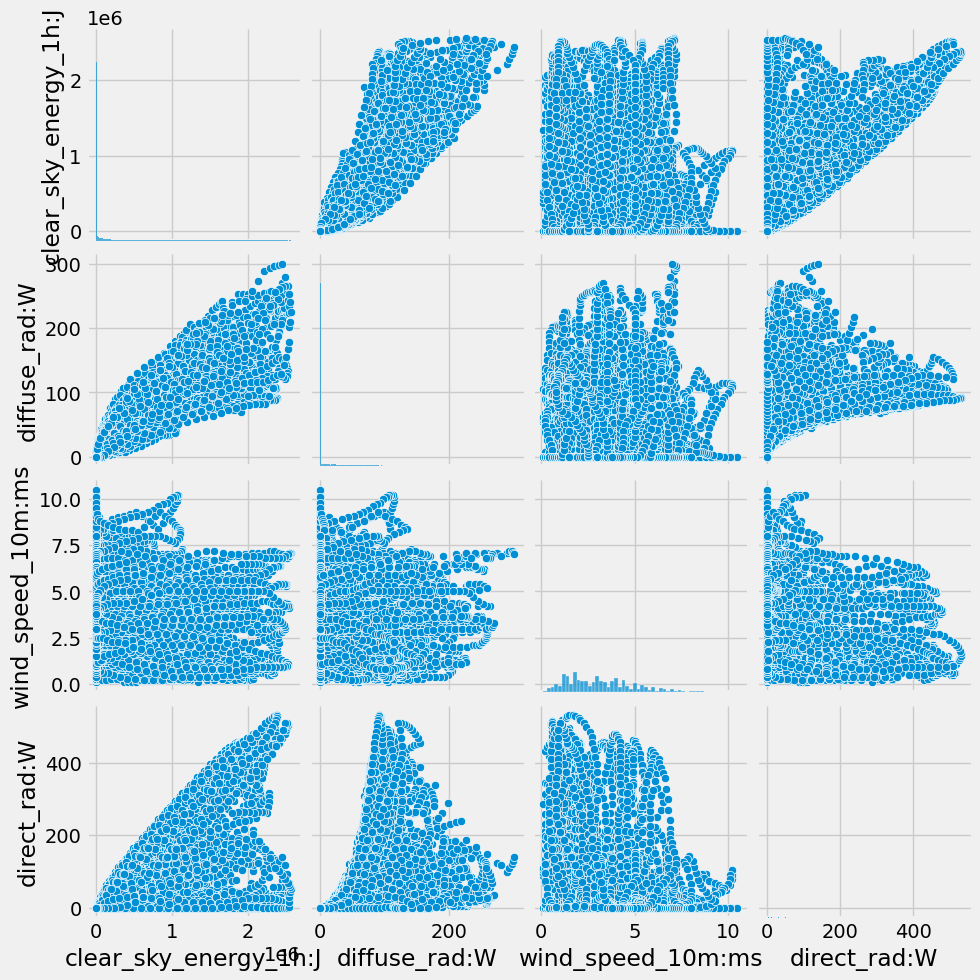

In [540]:
sns.pairplot(X_train_observed_a, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W'])
sns.pairplot(X_train_estimated_a, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W'])
plt.show()

In [541]:
df_corr = X_train_observed_a[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.911178   
diffuse_rad:W                       0.911178       1.000000   
wind_speed_10m:ms                   0.013025      -0.004529   
direct_rad:W                        0.719660       0.555213   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.013025      0.719660  
diffuse_rad:W                  -0.004529      0.555213  
wind_speed_10m:ms               1.000000     -0.095310  
direct_rad:W                   -0.095310      1.000000

In [542]:
df_corr = X_train_estimated_a[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.904585   
diffuse_rad:W                       0.904585       1.000000   
wind_speed_10m:ms                   0.035973       0.066920   
direct_rad:W                        0.756767       0.550829   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.035973      0.756767  
diffuse_rad:W                   0.066920      0.550829  
wind_speed_10m:ms               1.000000     -0.068388  
direct_rad:W                   -0.068388      1.000000

## Now let us explore location B

In [543]:
X_train_observed_b.head()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-01-01 00:00:00                       5.6                1.239   
1 2019-01-01 00:15:00                       5.6                1.239   
2 2019-01-01 00:30:00                       5.5                1.240   
3 2019-01-01 00:45:00                       5.4                1.241   
4 2019-01-01 01:00:00                       5.4                1.241   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1226.400024                    0.0              0.0   
1           1209.300049                    0.0              0.0   
2           1192.099976                    0.0              0.0   
3           1174.900024                    0.0              0.0   
4           1157.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1226.400024              0.0      275.399994            0.0  ...   
1       1209.300049              0.0      275.200012            0.0  ...   
2       1192.099976              0.0      275.100006            0.0  ...   
3       1174.900024              0.0      274.899994            0.0  ...   
4       1157.599976              0.0      274.700012            0.0  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0      12.985000       -49.139999                             0.0   
1      18.205999       -48.688000                             0.0   
2      23.339001       -48.091000                             0.0   
3      28.367001       -47.358002                             0.0   
4      33.275002       -46.497002                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   278.399994            73.900002  19275.900391                2.5   
1   278.299988            83.800003  17638.000000                2.7   
2   278.200012            91.199997  16008.799805                2.9   
3   278.100006            96.400002  14388.500000                3.1   
4   278.000000            99.400002  12777.299805                3.4   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                  1.1                  2.2                     -0.0  
1                  1.2                  2.4                     -0.0  
2                  1.2                  2.7                     -0.0  
3                  1.2                  2.9                     -0.0  
4                  1.3                  3.1                     -0.0  

[5 rows x 46 columns]

In [544]:
X_train_estimated_b.head()

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2022-10-27 07:00:18 2022-10-28 22:00:00                       8.4   
1 2022-10-27 07:00:18 2022-10-28 22:15:00                       8.4   
2 2022-10-27 07:00:18 2022-10-28 22:30:00                       8.4   
3 2022-10-27 07:00:18 2022-10-28 22:45:00                       8.4   
4 2022-10-27 07:00:18 2022-10-28 23:00:00                       8.5   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.233           1425.099976                    0.0   
1                1.233           2086.000000                    0.0   
2                1.232           2746.899902                    0.0   
3                1.232           3407.800049                    0.0   
4                1.231           4068.699951                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1211.900024              1.0      281.399994  ...   
1              0.0       1562.500000              1.0      281.399994  ...   
2              0.0       1913.099976              1.0      281.500000  ...   
3              0.0       2263.699951              1.0      281.500000  ...   
4              0.0       2614.300049              1.0      281.500000  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     340.799988       -38.466000                             0.0   
1     345.453003       -38.955002                             0.0   
2     350.153992       -39.310001                             0.0   
3     354.888000       -39.528999                             0.0   
4     359.639008       -39.609001                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   284.700012                100.0  29393.500000                0.8   
1   284.700012                100.0  23576.500000                0.7   
2   284.700012                100.0  17780.300781                0.7   
3   284.600006                100.0  12005.099609                0.6   
4   284.600006                100.0   6250.600098                0.6   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -0.4                  0.7                     -0.0  
1                 -0.4                  0.6                     -0.0  
2                 -0.3                  0.6                     -0.0  
3                 -0.2                  0.6                     -0.0  
4                 -0.1                  0.6                     -0.0  

[5 rows x 47 columns]

In [545]:
X_train_estimated_b.shape, X_train_observed_b.shape

((17576, 47), (116929, 46))

In [546]:
X_train_observed_b.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [547]:
X_train_estimated_b.columns

Index(['date_calc', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_spe

In [548]:
X_train_observed_b.loc[X_train_observed_b.duplicated()], X_train_estimated_b.loc[X_train_estimated_b.duplicated()]

(Empty DataFrame
 Columns: [date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
 Index: []
 
 [0 rows x 46 columns],
 Empty DataFrame
 Columns: [date_calc, date_forecast, absolute_humidity_2m:gm3, a

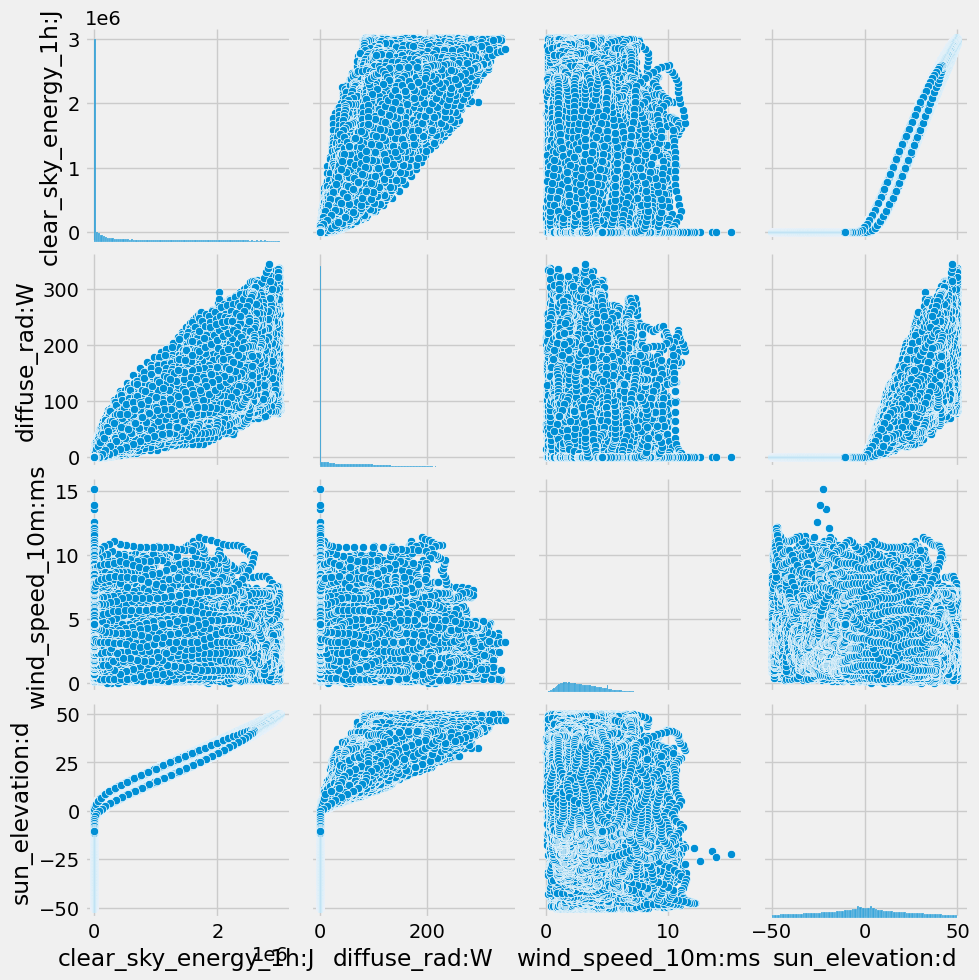

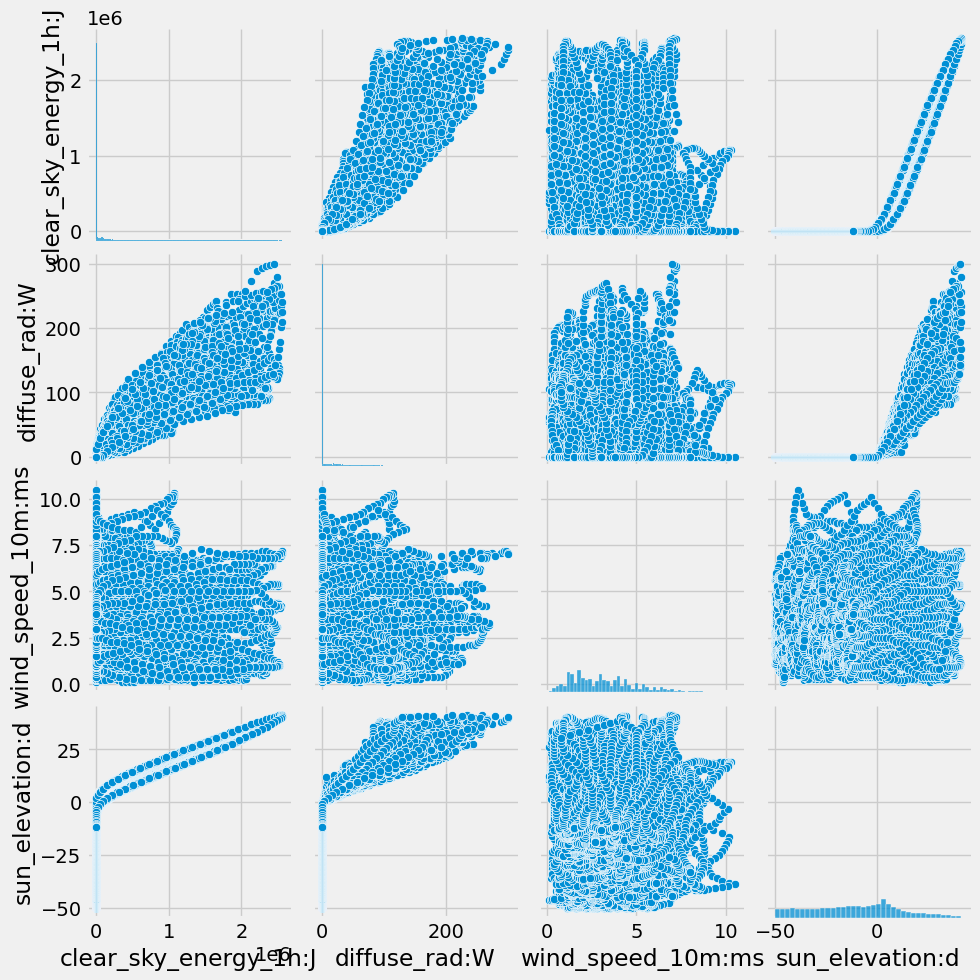

In [549]:
sns.pairplot(X_train_observed_b, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'sun_elevation:d'])
sns.pairplot(X_train_estimated_b, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'sun_elevation:d'])
plt.show()

In [550]:
df_corr = X_train_observed_b[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.910521   
diffuse_rad:W                       0.910521       1.000000   
wind_speed_10m:ms                   0.004644      -0.008523   
direct_rad:W                        0.738171       0.572789   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.004644      0.738171  
diffuse_rad:W                  -0.008523      0.572789  
wind_speed_10m:ms               1.000000     -0.102084  
direct_rad:W                   -0.102084      1.000000

In [551]:
df_corr = X_train_estimated_b[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.904608   
diffuse_rad:W                       0.904608       1.000000   
wind_speed_10m:ms                   0.036064       0.067110   
direct_rad:W                        0.756784       0.550859   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.036064      0.756784  
diffuse_rad:W                   0.067110      0.550859  
wind_speed_10m:ms               1.000000     -0.068302  
direct_rad:W                   -0.068302      1.000000

## Now for location C

In [552]:
X_train_observed_c.head()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-01-01 00:00:00                       5.6                1.240   
1 2019-01-01 00:15:00                       5.5                1.241   
2 2019-01-01 00:30:00                       5.4                1.241   
3 2019-01-01 00:45:00                       5.4                1.241   
4 2019-01-01 01:00:00                       5.3                1.241   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1153.599976                    0.0              0.0   
1           1137.900024                    0.0              0.0   
2           1122.199951                    0.0              0.0   
3           1106.400024                    0.0              0.0   
4           1090.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1153.599976              1.0      275.200012            0.0  ...   
1       1137.900024              1.0      275.100006            0.0  ...   
2       1122.199951              1.0      274.899994            0.0  ...   
3       1106.400024              1.0      274.700012            0.0  ...   
4       1090.599976              1.0      274.500000            0.0  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0      12.989000       -49.178001                             0.0   
1      18.214001       -48.724998                             0.0   
2      23.351000       -48.127998                             0.0   
3      28.382000       -47.393002                             0.0   
4      33.292999       -46.529999                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   278.500000            68.500000  18220.400391                2.5   
1   278.399994            80.800003  17083.699219                2.8   
2   278.299988            89.900002  15940.900391                3.0   
3   278.200012            96.099998  14792.000000                3.3   
4   278.100006            99.400002  13637.299805                3.5   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                  1.1                  2.2                     -0.0  
1                  1.1                  2.5                     -0.0  
2                  1.1                  2.8                     -0.0  
3                  1.2                  3.0                     -0.0  
4                  1.2                  3.3                     -0.0  

[5 rows x 46 columns]

In [553]:
X_train_estimated_c.head()

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2022-10-27 07:00:18 2022-10-28 22:00:00                       8.3   
1 2022-10-27 07:00:18 2022-10-28 22:15:00                       8.3   
2 2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3 2022-10-27 07:00:18 2022-10-28 22:45:00                       8.2   
4 2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.231           1427.400024                    0.0   
1                1.231           2089.000000                    0.0   
2                1.231           2750.500000                    0.0   
3                1.230           3412.100098                    0.0   
4                1.230           4073.699951                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1215.800049              1.0      281.200012  ...   
1              0.0       1425.900024              1.0      281.200012  ...   
2              0.0       1636.099976              1.0      281.100006  ...   
3              0.0       1846.199951              1.0      281.100006  ...   
4              0.0       2056.399902              1.0      281.100006  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     340.785004       -38.502998                             0.0   
1     345.440002       -38.992001                             0.0   
2     350.144012       -39.348000                             0.0   
3     354.880005       -39.567001                             0.0   
4     359.634003       -39.647999                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   285.200012                100.0  34387.398438                1.2   
1   285.100006                100.0  27418.500000                1.2   
2   285.100006                100.0  20508.800781                1.2   
3   285.000000                100.0  13657.799805                1.2   
4   285.000000                100.0   6865.000000                1.2   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -0.3                  1.1                     -0.0  
1                 -0.2                  1.2                     -0.0  
2                 -0.1                  1.2                     -0.0  
3                 -0.0                  1.2                     -0.0  
4                  0.1                  1.2                     -0.0  

[5 rows x 47 columns]

In [554]:
X_train_observed_c.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [555]:
X_train_estimated_c.columns

Index(['date_calc', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_spe

In [556]:
X_train_observed_c.loc[X_train_observed_c.duplicated()], X_train_estimated_c.loc[X_train_estimated_c.duplicated()]

(Empty DataFrame
 Columns: [date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
 Index: []
 
 [0 rows x 46 columns],
 Empty DataFrame
 Columns: [date_calc, date_forecast, absolute_humidity_2m:gm3, a

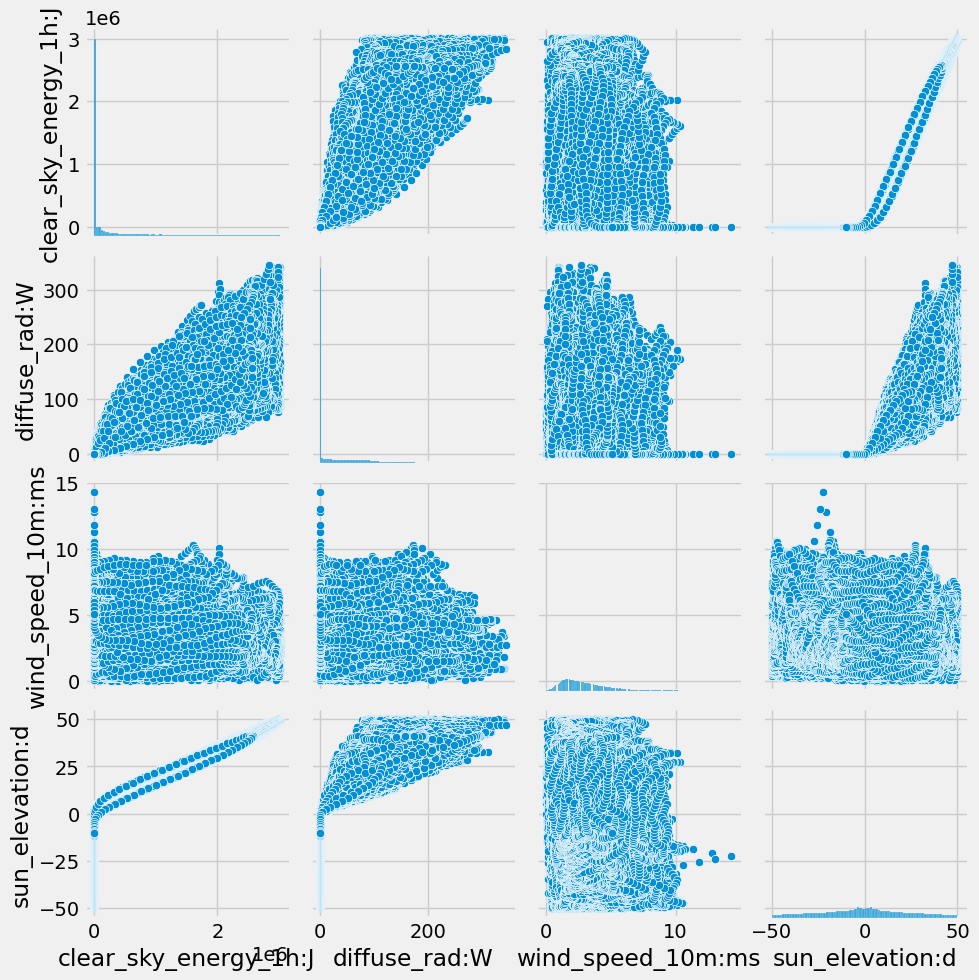

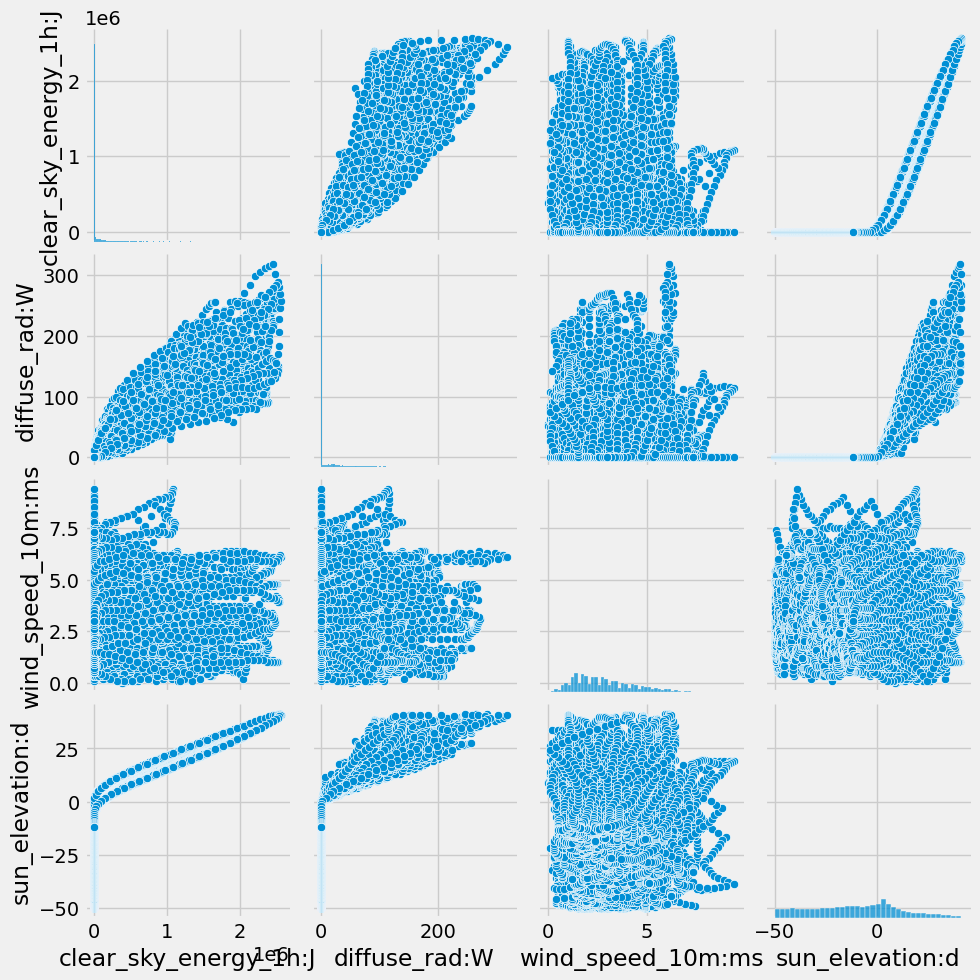

In [557]:
sns.pairplot(X_train_observed_c, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'sun_elevation:d'])
sns.pairplot(X_train_estimated_c, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'sun_elevation:d'])
plt.show()

In [558]:
df_corr = X_train_observed_c[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.908930   
diffuse_rad:W                       0.908930       1.000000   
wind_speed_10m:ms                   0.005627      -0.008779   
direct_rad:W                        0.731325       0.570156   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.005627      0.731325  
diffuse_rad:W                  -0.008779      0.570156  
wind_speed_10m:ms               1.000000     -0.088943  
direct_rad:W                   -0.088943      1.000000

In [559]:
df_corr = X_train_estimated_c[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.902190   
diffuse_rad:W                       0.902190       1.000000   
wind_speed_10m:ms                   0.012182       0.041042   
direct_rad:W                        0.753555       0.547727   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.012182      0.753555  
diffuse_rad:W                   0.041042      0.547727  
wind_speed_10m:ms               1.000000     -0.093965  
direct_rad:W                   -0.093965      1.000000

### Looking at describe()

In [560]:
train_a.describe()

time  pv_measurement
count                       34085    34085.000000
mean   2021-05-14 00:29:51.497726      630.594707
min           2019-06-02 22:00:00        0.000000
25%           2020-05-22 23:00:00        0.000000
50%           2021-05-13 00:00:00        5.940000
75%           2022-05-03 01:00:00      678.040000
max           2023-04-30 23:00:00     5733.420000
std                           NaN     1165.902422

In [561]:
train_b.describe()

time  pv_measurement
count                       32848    32844.000000
mean   2020-12-07 17:46:02.031173       96.824778
min           2018-12-31 23:00:00       -0.000000
25%           2019-12-09 05:45:00       -0.000000
50%           2020-11-15 12:30:00        0.000000
75%           2021-10-23 17:15:00       96.600000
max           2023-04-30 23:00:00     1152.300000
std                           NaN      193.946487

In [562]:
train_c.describe()

time  pv_measurement
count                       32155    26095.000000
mean   2020-11-20 18:02:22.186285       77.631060
min           2018-12-31 23:00:00       -0.000000
25%           2019-12-01 23:30:00        0.000000
50%           2020-11-01 00:00:00        0.000000
75%           2021-10-01 22:30:00       58.800000
max           2023-04-30 23:00:00      999.600000
std                           NaN      165.816877

In [563]:
X_train_observed_a.describe()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
count               118669             118669.000000        118669.000000   
mean   2021-02-09 23:30:00                  6.652576             1.249064   
min    2019-06-02 22:00:00                  0.700000             1.145000   
25%    2020-04-06 22:45:00                  4.400000             1.224000   
50%    2021-02-09 23:30:00                  6.300000             1.247000   
75%    2021-12-16 00:15:00                  8.600000             1.272000   
max    2022-10-21 01:00:00                 17.500000             1.427000   
std                    NaN                  2.796349             0.036319   

       ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
count          96422.000000           1.186690e+05    118669.000000   
mean            2907.949219           5.994018e+05       166.500381   
min               27.799999           0.000000e+00         0.000000   
25%             1102.900024           0.000000e+00         0.000000   
50%             1882.400024           3.574770e+04         8.600000   
75%             3969.750000           1.037819e+06       288.799988   
max            12328.500000           3.005720e+06       836.400024   
std             2570.413086           8.795423e+05       244.945358   

       cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
count     110603.000000    118669.000000   118669.000000  118669.000000  ...   
mean        1737.142212         0.022398      276.823395      44.918282  ...   
min           27.900000        -1.000000      250.899994       0.000000  ...   
25%          590.700012         0.000000      272.100006       0.000000  ...   
50%         1162.599976         0.000000      277.200012       4.100000  ...   
75%         2079.600098         0.000000      282.000000      76.000000  ...   
max        11688.700195         1.000000      293.799988     345.700012  ...   
std         1815.584106         0.190367        6.701763      64.786697  ...   

       sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
count  118669.000000    118669.000000                   118669.000000   
mean      179.629486         1.529545                        0.059087   
min         0.002000       -50.004002                        0.000000   
25%        88.487999       -15.066000                        0.000000   
50%       179.436996         1.202000                        0.000000   
75%       270.640991        18.995001                        0.100000   
max       359.997986        49.999001                        1.400000   
std       103.779366        24.146885                        0.109496   

         t_1000hPa:K  total_cloud_cover:p   visibility:m  wind_speed_10m:ms  \
count  118669.000000        118669.000000  118669.000000      118669.000000   
mean      280.708557            74.401077   32446.992188           3.043197   
min       258.899994             0.000000     154.300003           0.000000   
25%       275.899994            54.799999   15592.400391           1.700000   
50%       280.700012            93.699997   36359.800781           2.700000   
75%       285.200012            99.900002   48084.500000           4.100000   
max       303.299988           100.000000   71349.898438          15.200000   
std         6.573763            33.515800   17968.044922           1.779247   

       wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
count        118669.000000        118669.000000            118669.000000  
mean              0.756781             0.517437                 0.000019  
min              -7.300000            -9.300000                -0.000000  
25%              -1.400000            -0.700000                 0.000000  
50%               0.400000             0.500000                 0.000000  
75%               2.700000             1.700000                 0.000000  
max              12.300000             8.600000                

In [564]:
X_train_observed_b.describe()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
count               116929             116929.000000        116929.000000   
mean   2020-09-01 00:00:00                  6.125604             1.254262   
min    2019-01-01 00:00:00                  0.700000             1.151000   
25%    2019-11-01 12:00:00                  4.100000             1.230000   
50%    2020-09-01 00:00:00                  5.500000             1.254000   
75%    2021-07-02 12:00:00                  8.000000             1.277000   
max    2022-05-03 00:00:00                 17.500000             1.426000   
std                    NaN                  2.727944             0.035289   

       ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
count          98157.000000           1.169290e+05    116929.000000   
mean            2651.450439           5.421514e+05       150.597580   
min               27.799999           0.000000e+00         0.000000   
25%             1037.900024           0.000000e+00         0.000000   
50%             1732.300049           1.271020e+04         0.000000   
75%             3412.199951           8.693612e+05       242.000000   
max            12328.799805           3.005700e+06       836.400024   
std             2404.853516           8.400522e+05       233.948273   

       cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
count     109456.000000    116929.000000   116929.000000  116929.000000  ...   
mean        1731.706665         0.008484      275.524536      40.894447  ...   
min           27.900000        -1.000000      250.899994       0.000000  ...   
25%          648.799988         0.000000      271.100006       0.000000  ...   
50%         1219.800049         0.000000      275.299988       0.000000  ...   
75%         2074.100098         0.000000      280.799988      69.000000  ...   
max        11688.900391         1.000000      293.799988     345.700012  ...   
std         1726.011108         0.117327        6.773766      61.530506  ...   

       sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
count  116929.000000    116929.000000                   116929.000000   
mean      179.569458        -0.322831                        0.059315   
min         0.002000       -50.004002                        0.000000   
25%        89.507004       -17.388000                        0.000000   
50%       179.457001        -0.276000                        0.000000   
75%       269.739014        16.606001                        0.100000   
max       359.998993        49.998001                        1.400000   
std       103.222916        24.058186                        0.110211   

         t_1000hPa:K  total_cloud_cover:p   visibility:m  wind_speed_10m:ms  \
count  116929.000000        116929.000000  116929.000000      116929.000000   
mean      279.630524            73.500275   33040.113281           3.122094   
min       258.899994             0.000000     169.199997           0.000000   
25%       275.000000            52.700001   16502.699219           1.700000   
50%       278.799988            92.599998   37614.101562           2.800000   
75%       284.200012            99.900002   48268.601562           4.200000   
max       303.299988           100.000000   70618.898438          15.200000   
std         6.634622            33.893852   18019.267578           1.827768   

       wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
count        116929.000000        116929.000000            116929.000000  
mean              0.750841             0.548524                 0.000027  
min              -7.300000            -9.300000                -0.000000  
25%              -1.500000            -0.700000                 0.000000  
50%               0.400000             0.600000                 0.000000  
75%               2.700000             1.700000                 0.000000  
max              12.400000             8.600000                

In [565]:
X_train_observed_c.describe()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
count               116825             116825.000000        116825.000000   
mean   2020-08-31 11:00:00                  6.013866             1.253214   
min    2019-01-01 00:00:00                  0.500000             1.139000   
25%    2019-11-01 05:30:00                  4.000000             1.228000   
50%    2020-08-31 11:00:00                  5.400000             1.253000   
75%    2021-07-01 16:30:00                  7.900000             1.277000   
max    2022-05-01 22:00:00                 18.900000             1.441000   
std                    NaN                  2.789840             0.038392   

       ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
count          96902.000000           1.168250e+05    116825.000000   
mean            2605.747559           5.423583e+05       150.655075   
min               27.799999           0.000000e+00         0.000000   
25%              981.400024           0.000000e+00         0.000000   
50%             1643.000000           1.267980e+04         0.000000   
75%             3406.175049           8.698632e+05       242.000000   
max            12431.299805           3.007722e+06       837.000000   
std             2415.117920           8.404843e+05       234.069214   

       cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
count     108313.000000    116825.000000   116825.000000  116825.000000  ...   
mean        1710.178467        -0.013867      275.147400      40.920612  ...   
min           27.900000        -1.000000      247.300003       0.000000  ...   
25%          618.500000         0.000000      270.600006       0.000000  ...   
50%         1178.400024         0.000000      274.899994       0.000000  ...   
75%         2056.399902         0.000000      280.600006      68.900002  ...   
max        11665.700195         1.000000      295.100006     344.500000  ...   
std         1751.569336         0.369077        7.103381      61.696342  ...   

       sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
count  116825.000000    116825.000000                   116825.000000   
mean      179.576492        -0.334226                        0.062269   
min         0.003000       -50.042000                        0.000000   
25%        89.529999       -17.424999                        0.000000   
50%       179.462997        -0.288000                        0.000000   
75%       269.747009        16.603001                        0.100000   
max       359.998993        50.036999                        1.400000   
std       103.210327        24.077934                        0.114863   

         t_1000hPa:K  total_cloud_cover:p   visibility:m  wind_speed_10m:ms  \
count  116825.000000        116825.000000  116825.000000      116825.000000   
mean      279.682556            73.351135   33186.710938           2.855492   
min       257.899994             0.000000     130.600006           0.000000   
25%       275.000000            52.599998   16388.000000           1.600000   
50%       278.899994            93.300003   37765.199219           2.500000   
75%       284.299988            99.900002   48576.000000           3.800000   
max       303.200012           100.000000   72215.000000          14.300000   
std         6.675199            34.580784   18169.167969           1.632607   

       wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
count        116825.000000        116825.000000            116825.000000  
mean              0.739988             0.838296                 0.000211  
min              -6.300000            -8.800000                -0.100000  
25%              -0.900000            -0.500000                 0.000000  
50%               0.400000             0.900000                 0.000000  
75%               2.300000             2.000000                 0.000000  
max              11.400000             9.000000                

### About the dates of the observed sets

They differ slightly from each other. Notice than the range of dates are not necesseraily the same as in the output datasets. 

In [566]:
X_train_estimated_a.describe()

date_calc               date_forecast  \
count                       17576                       17576   
mean   2023-01-27 19:07:13.160673  2023-01-28 23:11:50.127446   
min           2022-10-27 07:00:18         2022-10-28 22:00:00   
25%           2022-12-12 08:00:05         2022-12-13 16:26:15   
50%           2023-01-28 08:00:04         2023-01-29 10:52:30   
75%           2023-03-15 08:00:04         2023-03-16 05:18:45   
max           2023-04-29 07:00:05         2023-04-30 23:45:00   
std                           NaN                         NaN   

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
count              17576.000000         17576.000000          13657.000000   
mean                   4.092438             1.281746           3257.459473   
min                    1.000000             1.212000             27.900000   
25%                    3.000000             1.262000           1185.500000   
50%                    3.900000             1.279000           2750.000000   
75%                    5.100000             1.301000           4775.500000   
max                    8.800000             1.374000          12307.700195   
std                    1.511150             0.030050           2501.798340   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
count           1.757600e+04     17576.000000      15482.000000   
mean            2.371263e+05        65.868149       1575.233032   
min             0.000000e+00         0.000000         27.799999   
25%             0.000000e+00         0.000000        497.524994   
50%             0.000000e+00         0.000000        935.750000   
75%             1.374874e+05        37.400002       1919.599976   
max             2.555980e+06       711.599976      10813.700195   
std             5.173435e+05       144.162888       1718.795166   

       dew_or_rime:idx  dew_point_2m:K  ...  sun_azimuth:d  sun_elevation:d  \
count      17576.00000    17576.000000  ...   17576.000000     17576.000000   
mean           0.00899      270.222351  ...     179.677383       -10.692363   
min           -1.00000      254.699997  ...       0.013000       -50.004002   
25%            0.00000      266.799988  ...      94.669249       -28.210751   
50%            0.00000      270.399994  ...     179.510498        -9.930000   
75%            0.00000      273.899994  ...     264.569756         4.489000   
max            1.00000      282.100006  ...     359.990997        41.195000   
std            0.22154        5.215952  ...     100.143951        21.688938   

       super_cooled_liquid_water:kgm2   t_1000hPa:K  total_cloud_cover:p  \
count                    17576.000000  17576.000000         17576.000000   
mean                         0.032556    274.722656            73.760681   
min                          0.000000    259.700012             0.000000   
25%                          0.000000    271.799988            49.099998   
50%                          0.000000    274.700012            97.099998   
75%                          0.000000    277.799988           100.000000   
max                          0.900000    285.899994           100.000000   
std                          0.081630      4.639275            35.812218   

       visibility:m  wind_speed_10m:ms  wind_speed_u_10m:ms  \
count  17576.000000       17576.000000         17576.000000   
mean   33458.078125           3.183540            -0.015197   
min      190.500000           0.100000            -7.200000   
25%    19838.000488           1.700000            -2.200000   
50%    34456.800781           2.900000            -0.300000   
75%    47726.226562           4.300000             1.600000   
max    68498.500000          10.500000            10.100000   
std    16935.798828           1.790912             3.061202   

       wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
count         17576.000000                  17576.0  
mean              0.926172                      0.0  
min 

In [567]:
X_train_estimated_b.describe()

date_calc               date_forecast  \
count                       17576                       17576   
mean   2023-01-27 19:07:13.160673  2023-01-28 23:11:50.127446   
min           2022-10-27 07:00:18         2022-10-28 22:00:00   
25%           2022-12-12 08:00:05         2022-12-13 16:26:15   
50%           2023-01-28 08:00:04         2023-01-29 10:52:30   
75%           2023-03-15 08:00:04         2023-03-16 05:18:45   
max           2023-04-29 07:00:05         2023-04-30 23:45:00   
std                           NaN                         NaN   

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
count              17576.000000         17576.000000          13887.000000   
mean                   4.093150             1.280473           3247.021729   
min                    1.000000             1.210000             27.900000   
25%                    3.000000             1.261000           1180.500000   
50%                    3.900000             1.278000           2736.800049   
75%                    5.100000             1.299000           4755.000000   
max                    8.800000             1.370000          12316.700195   
std                    1.513466             0.029161           2496.413330   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
count           1.757600e+04     17576.000000      15613.000000   
mean            2.371212e+05        65.866737       1585.469604   
min             0.000000e+00         0.000000         27.799999   
25%             0.000000e+00         0.000000        499.500000   
50%             0.000000e+00         0.000000        940.099976   
75%             1.374692e+05        37.400002       1927.599976   
max             2.555956e+06       711.599976      10814.500000   
std             5.173369e+05       144.161041       1732.807373   

       dew_or_rime:idx  dew_point_2m:K  ...  sun_azimuth:d  sun_elevation:d  \
count     17576.000000    17576.000000  ...   17576.000000     17576.000000   
mean          0.007112      270.210114  ...     179.677994       -10.692382   
min          -1.000000      254.699997  ...       0.014000       -50.004002   
25%           0.000000      266.799988  ...      94.669998       -28.210751   
50%           0.000000      270.399994  ...     179.511497        -9.930000   
75%           0.000000      273.899994  ...     264.570740         4.488250   
max           1.000000      282.100006  ...     359.992004        41.195000   
std           0.152385        5.237202  ...     100.144035        21.688723   

       super_cooled_liquid_water:kgm2   t_1000hPa:K  total_cloud_cover:p  \
count                    17576.000000  17576.000000         17576.000000   
mean                         0.032556    274.723206            73.768616   
min                          0.000000    259.700012             0.000000   
25%                          0.000000    271.799988            49.074999   
50%                          0.000000    274.700012            97.099998   
75%                          0.000000    277.799988           100.000000   
max                          0.900000    285.899994           100.000000   
std                          0.081651      4.638471            35.804649   

       visibility:m  wind_speed_10m:ms  wind_speed_u_10m:ms  \
count  17576.000000       17576.000000         17576.000000   
mean   34074.843750           3.187329            -0.016352   
min      201.300003           0.100000            -7.200000   
25%    20174.124512           1.700000            -2.200000   
50%    35450.300781           2.900000            -0.300000   
75%    48549.625000           4.300000             1.600000   
max    69058.296875          10.500000            10.100000   
std    17252.943359           1.793228             3.067387   

       wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
count         17576.000000                  17576.0  
mean              0.922627                      0.0  
min 

In [568]:
X_train_estimated_c.describe()

date_calc               date_forecast  \
count                       17576                       17576   
mean   2023-01-27 19:07:13.160673  2023-01-28 23:11:50.127446   
min           2022-10-27 07:00:18         2022-10-28 22:00:00   
25%           2022-12-12 08:00:05         2022-12-13 16:26:15   
50%           2023-01-28 08:00:04         2023-01-29 10:52:30   
75%           2023-03-15 08:00:04         2023-03-16 05:18:45   
max           2023-04-29 07:00:05         2023-04-30 23:45:00   
std                           NaN                         NaN   

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
count              17576.000000         17576.000000          12980.000000   
mean                   3.927350             1.281578           3403.212646   
min                    0.800000             1.207000             27.600000   
25%                    2.800000             1.261000           1266.375000   
50%                    3.800000             1.278000           2871.149902   
75%                    4.900000             1.301000           4948.549805   
max                    8.900000             1.384000          12115.400391   
std                    1.573211             0.032246           2507.600098   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
count           1.757600e+04     17576.000000      14772.000000   
mean            2.376466e+05        66.013062       1738.442749   
min             0.000000e+00         0.000000         27.299999   
25%             0.000000e+00         0.000000        515.275024   
50%             0.000000e+00         0.000000        989.049988   
75%             1.388008e+05        37.799999       2067.024902   
max             2.558352e+06       712.299988      10725.599609   
std             5.180047e+05       144.348022       1914.490967   

       dew_or_rime:idx  dew_point_2m:K  ...  sun_azimuth:d  sun_elevation:d  \
count     17576.000000    17576.000000  ...   17576.000000     17576.000000   
mean         -0.093707      269.505615  ...     179.674271       -10.690556   
min          -1.000000      251.899994  ...       0.009000       -50.042000   
25%           0.000000      265.899994  ...      94.672752       -28.220250   
50%           0.000000      269.899994  ...     179.507996        -9.919500   
75%           0.000000      273.600006  ...     264.561249         4.516000   
max           1.000000      282.399994  ...     359.987000        41.234001   
std           0.408770        5.731794  ...     100.136139        21.710524   

       super_cooled_liquid_water:kgm2   t_1000hPa:K  total_cloud_cover:p  \
count                    17576.000000  17576.000000         17576.000000   
mean                         0.033546    274.769897            72.695808   
min                          0.000000    259.500000             0.000000   
25%                          0.000000    271.899994            46.375001   
50%                          0.000000    274.700012            97.400002   
75%                          0.000000    277.899994           100.000000   
max                          0.900000    286.100006           100.000000   
std                          0.083814      4.674097            37.268768   

       visibility:m  wind_speed_10m:ms  wind_speed_u_10m:ms  \
count  17576.000000       17576.000000         17576.000000   
mean   34643.558594           2.917200             0.150148   
min      160.199997           0.000000            -6.400000   
25%    20512.024902           1.700000            -1.500000   
50%    36348.650391           2.600000            -0.100000   
75%    49470.349609           3.900000             1.200000   
max    76737.796875           9.400000             9.200000   
std    17485.355469           1.589694             2.487083   

       wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
count         17576.000000             17576.000000  
mean              1.320397                -0.000762  
min 

### About the dates of the estimated sets

All estimated sets start at 2023-01-28 and end at 2023-04-30

## Visualizing the date discrepancies

Also including the test sets.

In [569]:
# ESTIMATED A
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

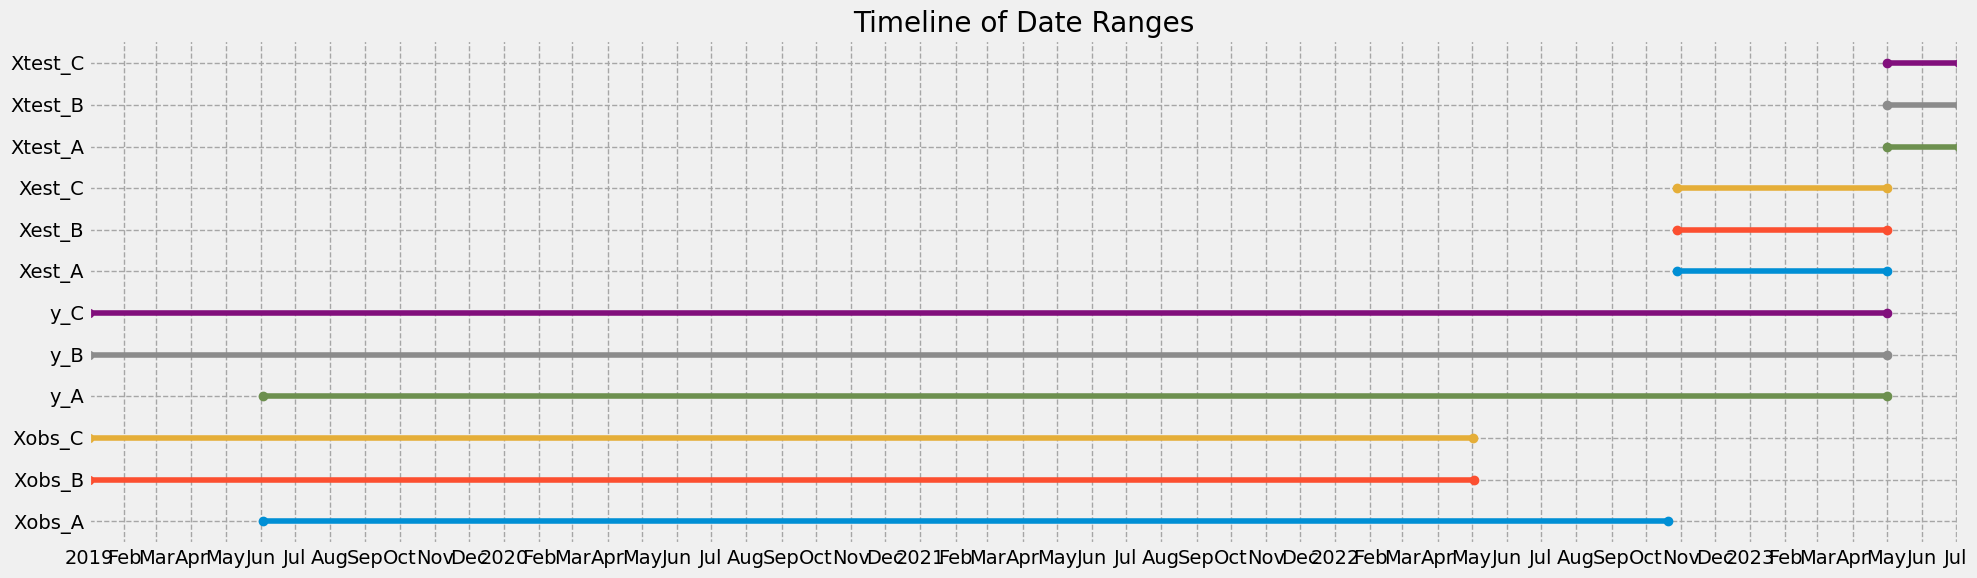

label                 min                 max
0    Xobs_A 2019-06-02 22:00:00 2022-10-21 01:00:00
1    Xobs_B 2019-01-01 00:00:00 2022-05-03 00:00:00
2    Xobs_C 2019-01-01 00:00:00 2022-05-01 22:00:00
3       y_A 2019-06-02 22:00:00 2023-04-30 23:00:00
4       y_B 2018-12-31 23:00:00 2023-04-30 23:00:00
5       y_C 2018-12-31 23:00:00 2023-04-30 23:00:00
6    Xest_A 2022-10-28 22:00:00 2023-04-30 23:45:00
7    Xest_B 2022-10-28 22:00:00 2023-04-30 23:45:00
8    Xest_C 2022-10-28 22:00:00 2023-04-30 23:45:00
9   Xtest_A 2023-05-01 00:00:00 2023-07-03 23:45:00
10  Xtest_B 2023-05-01 00:00:00 2023-07-03 23:45:00
11  Xtest_C 2023-05-01 00:00:00 2023-07-03 23:45:00

In [570]:
import matplotlib.dates as mdates

dataframes = [
            X_train_observed_a, X_train_observed_b, X_train_observed_c, 
            train_a, train_b, train_c,
            X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, 
            X_test_estimated_a, X_test_estimated_b, X_test_estimated_c
            ]

labels = ['Xobs_A', 'Xobs_B', 'Xobs_C', 'y_A', 'y_B', 'y_C', 'Xest_A', 'Xest_B', 'Xest_C' 
          ,'Xtest_A', 'Xtest_B', 'Xtest_C' ]

date_cols = [
    'date_forecast', 'date_forecast', 'date_forecast', 
    'time', 'time', 'time', 
    'date_forecast', 'date_forecast', 'date_forecast',
    'date_forecast', 'date_forecast', 'date_forecast'
]

min_max_dates = [(df[col].min(), df[col].max()) for df, col in zip(dataframes, date_cols)]

data = {'label': [], 'min': [], 'max': []}
for df, col, lab in zip(dataframes, date_cols, labels):
    data['label'].append(lab)
    data['min'].append(df[col].min())
    data['max'].append(df[col].max())
table = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlim(min(date[0] for date in min_max_dates), max(date[1] for date in min_max_dates))
ax.set_yticks(range(len(min_max_dates)))
ax.set_yticklabels([label for label in labels])
ax.set_title('Timeline of Date Ranges')

for index, (start, end) in enumerate(min_max_dates):
    ax.plot([start, end], [index, index], marker='o', linestyle='-')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

ax.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()

plt.show()

table

# Conclusion

- None of the datasets have duplicates
- The dates have an incremeants in chuncks of 15 min. Note this might be important as we are asked to predict for every hour, we might possibly have to take the average for the four quarters in every hour.
- The correlations between some select features differ slighly for every location (might have to research this point even further) 
- From the describe()-method it seems that location B and C have the same earliest recording in 2018, whilst A has it in 2019. This is in opposition to a graph shown some place above.
    - Notice that the number of rows in train_a, train_b and train_c differ
    - Even though the PV measurment of locaton A is much higher, the mean values for the features in the observed datasets of the different location are more or less the same. Hence the "scaling" issue seems to be exclusive to the y_sets.

# Making a model with some predictors

Some good predictors to use are **XGBoost** and **Random Forest**. In this part of the notebook we will try to create model predictions using these libraries, whilst taking some of the knowledge attained from the previous parts to do some feature engineering if needed.

Lets do some basic data preperation first before we input the dataset into the model. Moreover the plan is to use a huge pandas file containing data from all the location (all the training sets, observed and estimated).

In [1462]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

## Fixing the X set

In [1463]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b, 
                     X_train_estimated_b, X_train_observed_c, X_train_estimated_c], ignore_index=True)

X = X.drop("date_calc", axis=1)
X.set_index('date_forecast', inplace=True)
X = X.sort_index()

print(X.shape)
X.head()

(405151, 45)


absolute_humidity_2m:gm3  air_density_2m:kgm3  \
date_forecast                                                        
2019-01-01 00:00:00                       5.6                1.240   
2019-01-01 00:00:00                       5.6                1.239   
2019-01-01 00:15:00                       5.5                1.241   
2019-01-01 00:15:00                       5.6                1.239   
2019-01-01 00:30:00                       5.5                1.240   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
date_forecast                                                      
2019-01-01 00:00:00           1153.599976                    0.0   
2019-01-01 00:00:00           1226.400024                    0.0   
2019-01-01 00:15:00           1137.900024                    0.0   
2019-01-01 00:15:00           1209.300049                    0.0   
2019-01-01 00:30:00           1192.099976                    0.0   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
date_forecast                                                             
2019-01-01 00:00:00              0.0       1153.599976              1.0   
2019-01-01 00:00:00              0.0       1226.400024              0.0   
2019-01-01 00:15:00              0.0       1137.900024              1.0   
2019-01-01 00:15:00              0.0       1209.300049              0.0   
2019-01-01 00:30:00              0.0       1192.099976              0.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  ...  \
date_forecast                                                         ...   
2019-01-01 00:00:00      275.200012            0.0               0.0  ...   
2019-01-01 00:00:00      275.399994            0.0               0.0  ...   
2019-01-01 00:15:00      275.100006            0.0               0.0  ...   
2019-01-01 00:15:00      275.200012            0.0               0.0  ...   
2019-01-01 00:30:00      275.100006            0.0               0.0  ...   

                     sun_azimuth:d  sun_elevation:d  \
date_forecast                                         
2019-01-01 00:00:00      12.989000       -49.178001   
2019-01-01 00:00:00      12.985000       -49.139999   
2019-01-01 00:15:00      18.214001       -48.724998   
2019-01-01 00:15:00      18.205999       -48.688000   
2019-01-01 00:30:00      23.339001       -48.091000   

                     super_cooled_liquid_water:kgm2  t_1000hPa:K  \
date_forecast                                                      
2019-01-01 00:00:00                             0.0   278.500000   
2019-01-01 00:00:00                             0.0   278.399994   
2019-01-01 00:15:00                             0.0   278.399994   
2019-01-01 00:15:00                             0.0   278.299988   
2019-01-01 00:30:00                             0.0   278.200012   

                     total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
date_forecast                                                               
2019-01-01 00:00:00            68.500000  18220.400391                2.5   
2019-01-01 00:00:00            73.900002  19275.900391                2.5   
2019-01-01 00:15:00            80.800003  17083.699219                2.8   
2019-01-01 00:15:00            83.800003  17638.000000                2.7   
2019-01-01 00:30:00            91.199997  16008.799805                2.9   

                     wind_speed_u_10m:ms  wind_speed_v_10m:ms  \
date_forecast                                                   
2019-01-01 00:00:00                  1.1                  2.2   
2019-01-01 00:00:00                  1.1                  2.2   
2019-01-01 00:15:00                  1.1                  2.5   
2019-01-01 00:15:00                  1.2                  2.4   
2019-01-01 00:30:00                  1.2                  2.7   

                     wind_speed_w_1000hPa:ms  
date_forecast                                 
2019-01-01 00:00:00               

Taking the averages of the rows within each hour to use this as a representative measures for each of the features for every hour.

For example, 
The columns for 22:00 - 22:45 are taken the mean of. Then this serves as the new row for 22:00 (whilst not having 22:15- 22:45)

In [1464]:
X = X[['clear_sky_energy_1h:J', 'diffuse_rad:W', 'wind_speed_10m:ms',
                    'direct_rad:W', 'sun_elevation:d', 'is_day:idx']]

df_resampled = X.resample('60min').mean()

Checking if the aformentioned is done correctly

In [1465]:
hour_data = X['2023-04-30 15:00':'2023-04-30 15:59']
manual_averages = hour_data.mean()
print(manual_averages)
hour_data

clear_sky_energy_1h:J    1.715298e+06
diffuse_rad:W            1.586500e+02
wind_speed_10m:ms        6.724999e+00
direct_rad:W             1.545417e+02
sun_elevation:d          2.543175e+01
is_day:idx               1.000000e+00
dtype: float32


clear_sky_energy_1h:J  diffuse_rad:W  wind_speed_10m:ms  \
date_forecast                                                                  
2023-04-30 15:00:00            1870604.000     164.699997                7.0   
2023-04-30 15:00:00            1872132.000     169.600006                5.9   
2023-04-30 15:00:00            1870634.250     164.800003                7.0   
2023-04-30 15:15:00            1769821.125     160.199997                7.0   
2023-04-30 15:15:00            1769850.750     160.300003                7.0   
2023-04-30 15:15:00            1771211.625     166.800003                6.0   
2023-04-30 15:30:00            1664339.625     154.500000                7.1   
2023-04-30 15:30:00            1664310.625     154.399994                7.1   
2023-04-30 15:30:00            1665556.375     162.399994                6.1   
2023-04-30 15:45:00            1555759.500     152.800003                6.1   
2023-04-30 15:45:00            1554692.875     146.699997                7.2   
2023-04-30 15:45:00            1554664.875     146.600006                7.2   

                     direct_rad:W  sun_elevation:d  is_day:idx  
date_forecast                                                   
2023-04-30 15:00:00    178.399994        27.790001         1.0  
2023-04-30 15:00:00    172.199997        27.806999         1.0  
2023-04-30 15:00:00    178.399994        27.790001         1.0  
2023-04-30 15:15:00    165.699997        26.239000         1.0  
2023-04-30 15:15:00    165.600006        26.239000         1.0  
2023-04-30 15:15:00    154.300003        26.254000         1.0  
2023-04-30 15:30:00    152.699997        24.650000         1.0  
2023-04-30 15:30:00    152.800003        24.650000         1.0  
2023-04-30 15:30:00    137.000000        24.663000         1.0  
2023-04-30 15:45:00    125.400002        23.040001         1.0  
2023-04-30 15:45:00    135.899994        23.030001         1.0  
2023-04-30 15:45:00    136.100006        23.028999         1.0

In [1466]:
resampled_value = df_resampled.loc['2023-04-30 15:00']
print(resampled_value)


clear_sky_energy_1h:J    1.715298e+06
diffuse_rad:W            1.586500e+02
wind_speed_10m:ms        6.725000e+00
direct_rad:W             1.545417e+02
sun_elevation:d          2.543175e+01
is_day:idx               1.000000e+00
Name: 2023-04-30 15:00:00, dtype: float32


In [1467]:
X = df_resampled
X.head()

clear_sky_energy_1h:J  diffuse_rad:W  wind_speed_10m:ms  \
date_forecast                                                                  
2019-01-01 00:00:00                    0.0            0.0             2.8500   
2019-01-01 01:00:00                    0.0            0.0             3.6000   
2019-01-01 02:00:00                    0.0            0.0             3.9875   
2019-01-01 03:00:00                    0.0            0.0             4.7500   
2019-01-01 04:00:00                    0.0            0.0             5.7375   

                     direct_rad:W  sun_elevation:d  is_day:idx  
date_forecast                                                   
2019-01-01 00:00:00           0.0       -48.337624         0.0  
2019-01-01 01:00:00           0.0       -44.935123         0.0  
2019-01-01 02:00:00           0.0       -39.874874         0.0  
2019-01-01 03:00:00           0.0       -33.775249         0.0  
2019-01-01 04:00:00           0.0       -27.169001         0.0

## Fixing the y_set

Merging the x_train with y_train on valid dates. "date_forecast" is merged with "time". The rows are then sorted on time for convinence.

Also normaliziation is done since the pv_measurment values for location A are much higher. After the min-max scaling each value is scaled to the average max value from location B and C. It is assumened that this is the right scale.

**Note**
Location B has consant values at some points, this has NOT been fixed yet.

In [1468]:
# Min-Max on all y-sets separately

train_a['pv_measurement'] = ((train_a['pv_measurement'] - train_a['pv_measurement'].min()) / \
                        (train_a['pv_measurement'].max() - train_a['pv_measurement'].min()))

train_b['pv_measurement'] = ((train_b['pv_measurement'] - train_b['pv_measurement'].min()) / \
                        (train_b['pv_measurement'].max() - train_b['pv_measurement'].min()))

train_c['pv_measurement'] = ((train_c['pv_measurement'] - train_c['pv_measurement'].min()) / \
                        (train_c['pv_measurement'].max() - train_c['pv_measurement'].min()))

### A problem with the data from location B

In one instance location B has constant measurments, which is probably due to some malfunction.

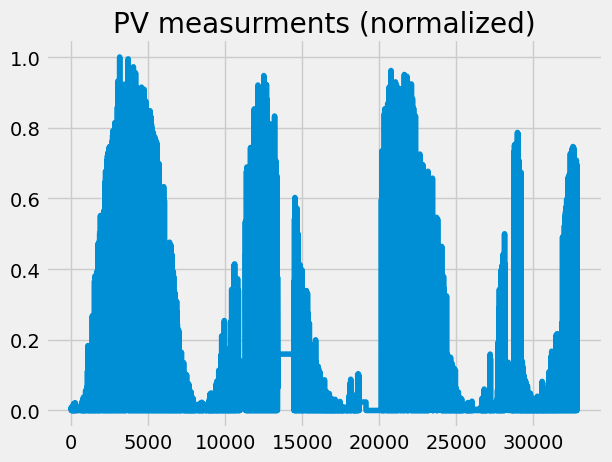

32848


In [1469]:
train_b['pv_measurement'].plot(title="PV measurments (normalized)")
plt.show()
print(len(train_b))

In [1470]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

interval = find_repeated_rows(train_b)[0]
print("The repeated rows interval is", interval)

start, end = int(interval[0]), int(interval[1])

The repeated rows interval is (13409, 14466)


First indentifying the constant values, then replacing them with NaN values. The idea is that these readings are wrong so they might as well be NaN values. Thereafter using spline interpolation to impute the missing values.

- I have only done this for the most prominent interval, it is however possible to control for more intervals. This is something we need to take in consideration.

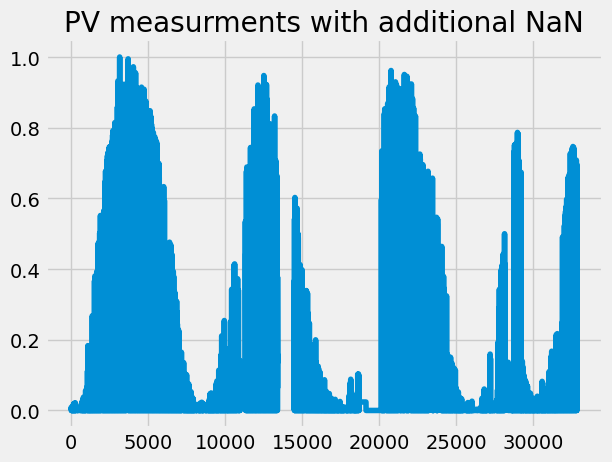

In [1471]:
for row_index in range(start, end + 1):
    train_b.at[row_index, 'pv_measurement'] = np.nan

train_b['pv_measurement'].plot(title="PV measurments with additional NaN")
plt.show()

Normal imputation methods like mean, median, spline interpolation and linear interpolation does not work well. This is because there is a large variation in dataset (day/night).

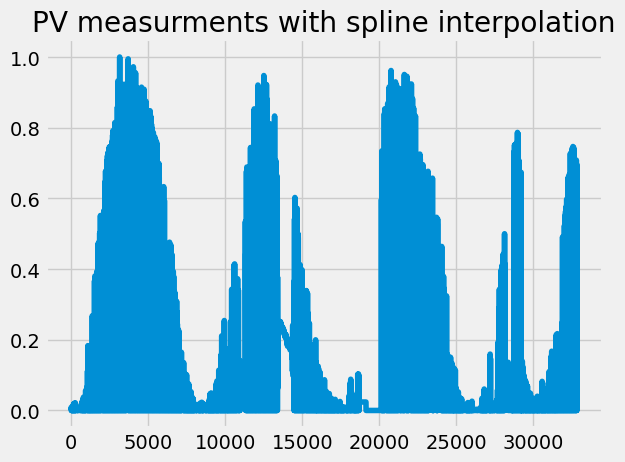

time              datetime64[us]
pv_measurement           float64
dtype: object

In [1472]:
test_set = train_b

test_set['pv_measurement'].fillna(test_set['pv_measurement'].rolling(window=984, min_periods=4).mean(), inplace=True)
test_set['pv_measurement'].interpolate(method='spline', inplace=True, order =3)

test_set['pv_measurement'].plot(title="PV measurments with spline interpolation")
plt.show()

displayed_df = test_set.iloc[start-10:end+1]
displayed_df

train_b.dtypes

What if we put them together?

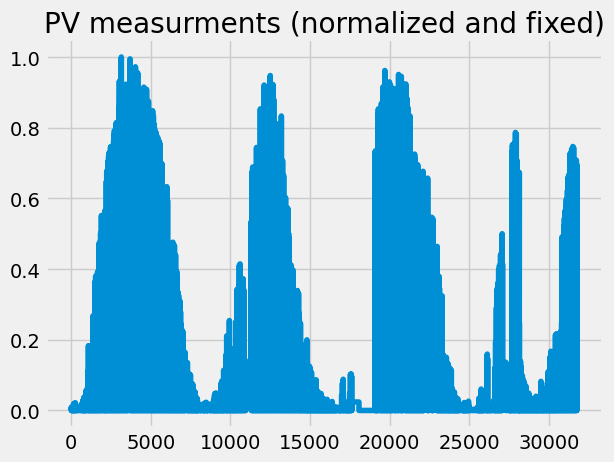

31790


In [1473]:
test_2 = train_b
test_2.drop(index=range(interval[0], interval[1]+1), inplace=True)
test_2 = train_b.reset_index(drop=True)


test_2['pv_measurement'].plot(title="PV measurments (normalized and fixed)")
plt.show()
print(len(test_2))

In [1474]:
y = pd.concat([train_a, train_b, train_c])
y['time'] = pd.to_datetime(y['time'])
y = y.set_index('time').resample('60min').mean()
y.head()

pv_measurement
time                               
2018-12-31 23:00:00             0.0
2019-01-01 00:00:00             0.0
2019-01-01 01:00:00             0.0
2019-01-01 02:00:00             0.0
2019-01-01 03:00:00             0.0

In [1475]:
df = pd.merge(y , X, left_index=True, right_index=True)
df = df.sort_index()
df.index.name = "time"
df.head()

pv_measurement  clear_sky_energy_1h:J  diffuse_rad:W  \
time                                                                        
2019-01-01 00:00:00             0.0                    0.0            0.0   
2019-01-01 01:00:00             0.0                    0.0            0.0   
2019-01-01 02:00:00             0.0                    0.0            0.0   
2019-01-01 03:00:00             0.0                    0.0            0.0   
2019-01-01 04:00:00             0.0                    0.0            0.0   

                     wind_speed_10m:ms  direct_rad:W  sun_elevation:d  \
time                                                                    
2019-01-01 00:00:00             2.8500           0.0       -48.337624   
2019-01-01 01:00:00             3.6000           0.0       -44.935123   
2019-01-01 02:00:00             3.9875           0.0       -39.874874   
2019-01-01 03:00:00             4.7500           0.0       -33.775249   
2019-01-01 04:00:00             5.7375           0.0       -27.169001   

                     is_day:idx  
time                             
2019-01-01 00:00:00         0.0  
2019-01-01 01:00:00         0.0  
2019-01-01 02:00:00         0.0  
2019-01-01 03:00:00         0.0  
2019-01-01 04:00:00         0.0

In [1476]:
def min_max(data):
    for column in data.columns:
        data[column] = ((data[column] - data[column].min()) / \
                                (data[column].max() - data[column].min()))
    
min_max(df)


In [1477]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

pv_measurement           190
clear_sky_energy_1h:J    212
diffuse_rad:W            212
wind_speed_10m:ms        212
direct_rad:W             212
sun_elevation:d          212
is_day:idx               212
dtype: int64
pv_measurement           0
clear_sky_energy_1h:J    0
diffuse_rad:W            0
wind_speed_10m:ms        0
direct_rad:W             0
sun_elevation:d          0
is_day:idx               0
dtype: int64
DROPNA RESULTED IN 214 ROWS BEING DROPED. THE DATASET HAS 37730 ROWS IN TOTAL.


## NOTE

Since the dataset from B and C does not have values somewhere between 2022 and 2023, the values for this area will be much larger. This is because the values from dataset A will overpower in the mean. 
    - This has been fixed using min-max scaling. I am not sure as to how effective this is. There are other methods one can use, although a little bit harder.

Also the wrong constant readings from location B must be accounted for.

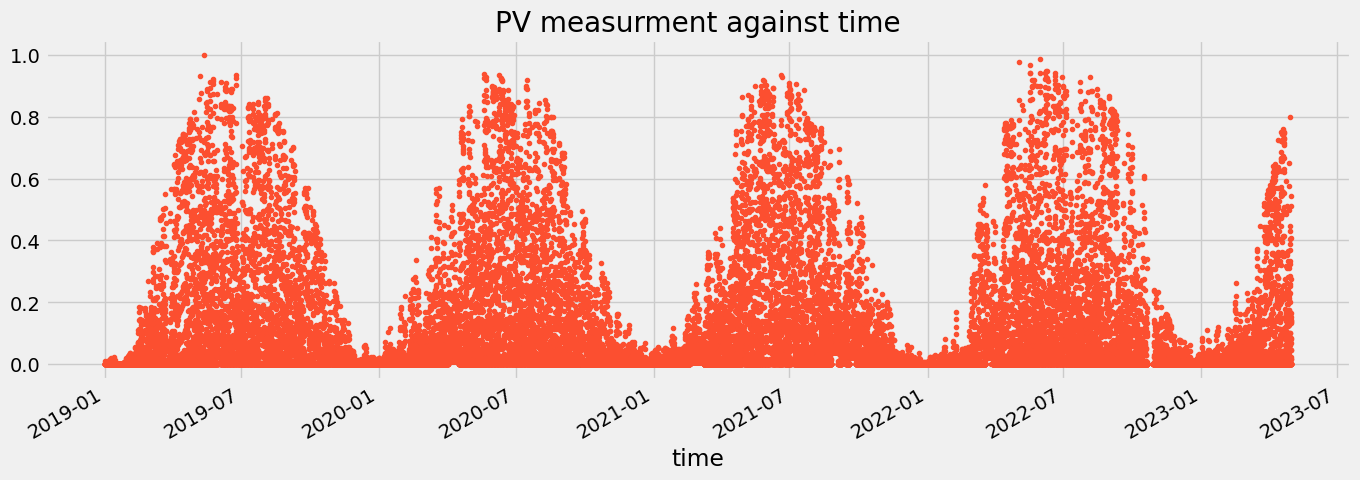

In [1478]:
color_pal = sns.color_palette()

df = df.dropna()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

Now let us look at potensial outliers.

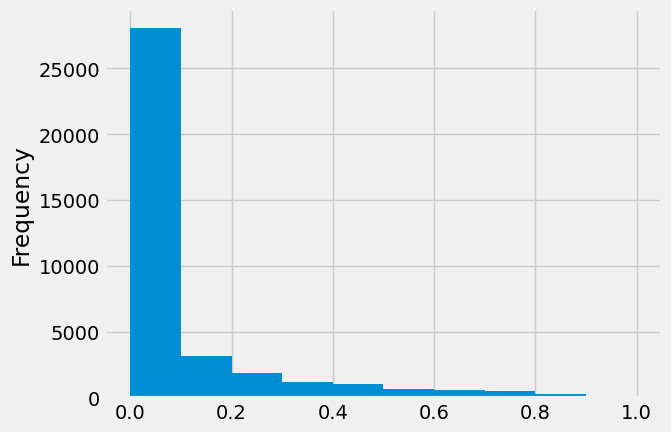

In [1479]:
df['pv_measurement'].plot(kind='hist', bins=10)
plt.show()

Not sure how to take outliers in consideration. I suspect that i have fixed for outliers when deploying min-max scaling.

### We must prepare the dataset for Timeseries

In [1480]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [1481]:
df.dtypes, df.shape

(pv_measurement           float64
 clear_sky_energy_1h:J    float32
 diffuse_rad:W            float32
 wind_speed_10m:ms        float32
 direct_rad:W             float32
 sun_elevation:d          float32
 is_day:idx               float32
 hour                       int32
 dayofweek                  int32
 quarter                    int32
 month                      int32
 year                       int32
 dayofyear                  int32
 dayofmonth                 int32
 weekofyear                UInt32
 dtype: object,
 (37730, 15))

## Now splitting the data into training and test data

Some considerations here are that we need both observed and estimated weatherdata in the training data. 

Possible methods:
- A random split
- Time series cross validation

In [1482]:
# The date in which the estimated data starts

X_train_estimated_a['date_forecast'].min()

Timestamp('2022-10-28 22:00:00')

### Time Series Cross Validation

In [1483]:
''' 
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=24*365, gap=24*30)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['pv_measurement'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['pv_measurement'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()
'''

" \nfrom sklearn.model_selection import TimeSeriesSplit\n\ntss = TimeSeriesSplit(n_splits=4, test_size=24*365, gap=24*30)\ndf = df.sort_index()\n\nfig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)\n\nfold = 0\nfor train_idx, val_idx in tss.split(df):\n    train = df.iloc[train_idx]\n    test = df.iloc[val_idx]\n    train['pv_measurement'].plot(ax=axs[fold],\n                          label='Training Set',\n                          title=f'Data Train/Test Split Fold {fold}')\n    test['pv_measurement'].plot(ax=axs[fold],\n                         label='Test Set')\n    axs[fold].axvline(test.index.min(), color='black', ls='--')\n    fold += 1\nplt.show()\n"

In [1484]:
# change this

'''
def add_lags(df):
    tmap = df['clear_sky_energy_1h:J'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(tmap)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(tmap)
    df['lag3'] = (df.index - pd.Timedelta('180 days')).map(tmap)
    return df

df = add_lags(df)
'''


"\ndef add_lags(df):\n    tmap = df['clear_sky_energy_1h:J'].to_dict()\n    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(tmap)\n    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(tmap)\n    df['lag3'] = (df.index - pd.Timedelta('180 days')).map(tmap)\n    return df\n\ndf = add_lags(df)\n"

Create testset

In [1485]:
# creating test feature set

X_test = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c], ignore_index=True)

X_test = X_test.drop("date_calc", axis=1)
X_test.set_index('date_forecast', inplace=True)
X_test = X_test.sort_index()

print(X_test.shape)

X_test = X_test[['clear_sky_energy_1h:J', 'diffuse_rad:W', 'wind_speed_10m:ms',
                    'direct_rad:W', 'sun_elevation:d', 'is_day:idx']]

df_test_resampled = X_test.resample('60min').mean()
X_test = df_test_resampled
X_test.head()

(8640, 45)


clear_sky_energy_1h:J  diffuse_rad:W  wind_speed_10m:ms  \
date_forecast                                                                  
2023-05-01 00:00:00               0.000000       0.000000           3.775000   
2023-05-01 01:00:00               0.000000       0.000000           3.658334   
2023-05-01 02:00:00               0.000000       0.000000           3.508333   
2023-05-01 03:00:00           10074.825195       9.349999           3.375000   
2023-05-01 04:00:00          141539.859375      47.574997           3.225000   

                     direct_rad:W  sun_elevation:d  is_day:idx  
date_forecast                                                   
2023-05-01 00:00:00      0.000000       -10.553083        0.00  
2023-05-01 01:00:00      0.000000        -7.905584        0.00  
2023-05-01 02:00:00      0.000000        -3.824750        0.00  
2023-05-01 03:00:00      1.400000         1.405500        0.75  
2023-05-01 04:00:00     26.383333         7.464083        1.00

In [1486]:
X_test = create_features(X_test)
#X_test = add_lags(X_test)
min_max(X_test)

In [1488]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Time Series Split
tss = TimeSeriesSplit(n_splits=4, test_size=24*365, gap=24*30)
df = df.sort_index()

# For the sake of this example, let's use the last split as our validation.
train_idx, val_idx = list(tss.split(df))[-1]
train = df.iloc[train_idx]
val = df.iloc[val_idx]

train = create_features(train)
val = create_features(val)


FEATURES = [
    'clear_sky_energy_1h:J', 'diffuse_rad:W', 'wind_speed_10m:ms', 'direct_rad:W', 
    'sun_elevation:d', 'is_day:idx', 'hour', 'dayofweek', 'quarter', 'month', 
    'year', 'dayofyear', 'dayofmonth', 'weekofyear'
]
TARGET = 'pv_measurement'

X_train = train[FEATURES]
y_train = train[TARGET]

X_val = val[FEATURES]
y_val = val[TARGET]

y_min = y_train.min()
y_max = y_train.max()

# Initialize and train model
reg = xgb.XGBRegressor(
    base_score=0.5, 
    booster='gbtree',
    n_estimators=500,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.01
)
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    early_stopping_rounds=50,
    verbose=100
)

X_test_new = X_test[FEATURES]

predictions = reg.predict(X_test_new)

predictions_denormalized = predictions

# Save predictions to CSV with index
predictions = pd.DataFrame(predictions, columns=['prediction'])
predictions['time'] = X_test_new.index
predictions.set_index('time', inplace=True)
#predictions.reset_index(inplace=True)
#predictions.rename(columns={'index': 'id'}, inplace=True)
#predictions.to_csv('predictions.csv', index=False)

[0]	validation_0-rmse:0.43891	validation_1-rmse:0.43568


/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning:

[100]	validation_0-rmse:0.17263	validation_1-rmse:0.17565
[200]	validation_0-rmse:0.08684	validation_1-rmse:0.09609
[300]	validation_0-rmse:0.06621	validation_1-rmse:0.07909
[400]	validation_0-rmse:0.06220	validation_1-rmse:0.07658
[499]	validation_0-rmse:0.06117	validation_1-rmse:0.07608


/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning:

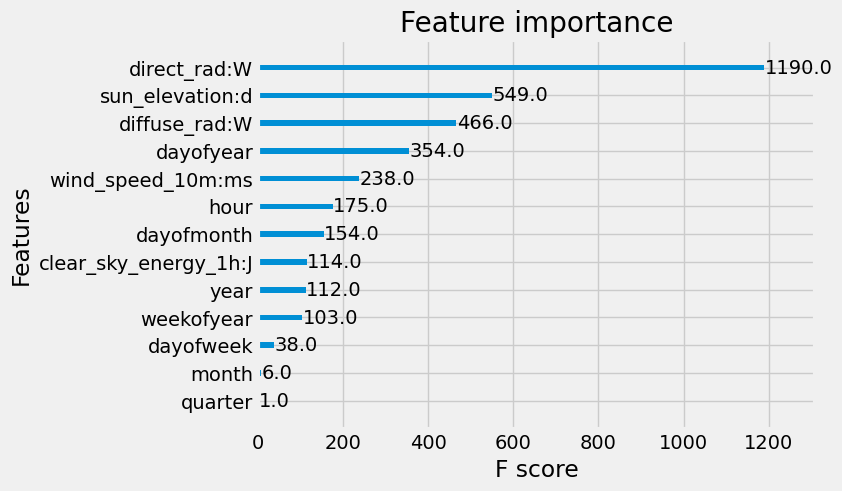

In [1489]:
xgb.plot_importance(reg)
plt.show()

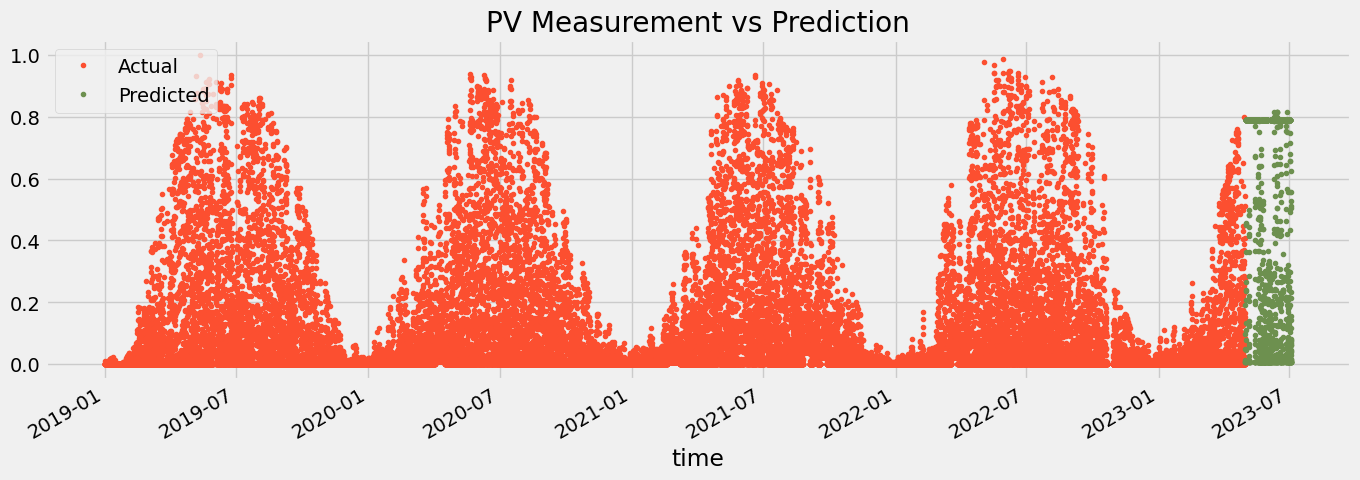

In [1496]:
plt.figure(figsize=(15, 5))

# Plot the actual pv_measurement values
df["pv_measurement"].plot(style='.', color=color_pal[1], title='PV Measurement vs Prediction')

# Plot the predicted values
predictions['prediction'].plot(style='.', color=color_pal[3])

# Add a legend to distinguish between actual and predicted values
plt.legend(['Actual', 'Predicted'], loc='upper left')

# Display the plot
plt.show()